In [69]:
import pandas as pd
import numpy as np
import datetime as dt
import sklearn as sk
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import wilcoxon
import statistics 

In [2]:
readmit_model1 = pd.read_csv(r'C:\Users\brthompson\bt_school\data\interim\readmit_model1.csv')
readmit_model2 = pd.read_csv(r'C:\Users\brthompson\bt_school\data\interim\secondmodel_readmit.csv')


In [3]:
readmit_model1.shape, readmit_model2.shape

((73283, 126), (73283, 129))

In [4]:
#Split dependent and independent variables
Xad = readmit_model1.drop(['readmit'], 1) #Features
Yad = readmit_model1['readmit'] #Target variable
Xad.shape, Yad.shape

((73283, 125), (73283,))

Determining optimal model parameters

[(3, 0.6432050443826155), (4, 0.6446514987958578), (5, 0.6518150636966009), (6, 0.6782332014245321), (7, 0.6929846267065353), (8, 0.7057160298744103), (9, 0.7074763712594581), (10, 0.7081449825918275), (11, 0.7074490367890535), (12, 0.7076946578734026), (13, 0.7077765272249301), (14, 0.7086771757298486), (15, 0.709277576102578), (16, 0.7100007902744151), (17, 0.7112698634232297), (18, 0.7117747760872393), (19, 0.7121159407422161), (20, 0.7121568702960398), (21, 0.7123342320108641), (22, 0.7117474593089266), (23, 0.7122660024340604), (24, 0.7120340229824551), (25, 0.7117883981738096), (26, 0.7117611083906444), (27, 0.71237509267619), (28, 0.7115154640313792), (29, 0.7124023424254217), (30, 0.7123068081664883), (31, 0.7125933783568054), (32, 0.7115154193413449), (33, 0.7115563321386924), (34, 0.7112152484804651), (35, 0.7111743030989207), (36, 0.7111060791058306), (37, 0.7120475733781266), (38, 0.7118701855964022), (39, 0.7113517141563234), (40, 0.7118838281606964), (41, 0.71196571054516

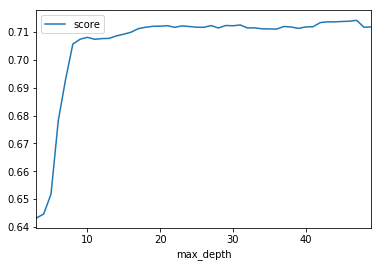

In [5]:
#Decision tree
#Use cross-validation for hyperparamter tuning - choose the best max_depth
depth = []
for i in range(3, 50):

    clf = DecisionTreeClassifier(max_depth=i) 
    scores = cross_val_score(estimator=clf, X = Xad, y = Yad, cv = 5, n_jobs = 4)
    depth.append((i, scores.mean()))
print(depth)
pd.DataFrame(depth, columns = ['max_depth', 'score']).set_index('max_depth').plot()
#Stabilizes at approximately 8


In [7]:
clf_tree = DecisionTreeClassifier(max_depth=8)

[(25, 0.7124434628372177), (50, 0.7098916078731905), (75, 0.7079812057295002), (100, 0.7076809920442277), (125, 0.7078174446856199), (150, 0.7075309033559655), (175, 0.7077628762904011), (200, 0.707735574403558), (225, 0.7073807764958543)]


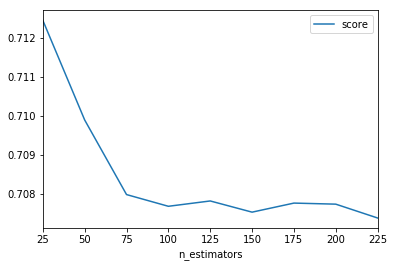

In [8]:
#Now determine best number of estimators for Boosted Decision Tree
#Use only the training set for the cross-validation
estimators = []
for i in range(25, 250, 25):

    clf = AdaBoostClassifier(base_estimator = clf_tree, random_state=0, n_estimators = i) 
    scores = cross_val_score(estimator=clf, X = Xad, y = Yad, cv = 5, n_jobs = 4)
    estimators.append((i, scores.mean()))
print(estimators)
pd.DataFrame(estimators, columns = ['n_estimators', 'score']).set_index('n_estimators').plot()
#max score achieved with 25 estimators

In [9]:
booster = AdaBoostClassifier(base_estimator = clf_tree, random_state=0, n_estimators = 25) 

[(50, 0.7122658990930562), (60, 0.7126889479921734), (70, 0.7125797404463258), (80, 0.7129345290433514), (90, 0.7122386316530028), (100, 0.7134394277422333), (110, 0.7124432784957803), (120, 0.7123204749372494), (130, 0.7127434763549835), (140, 0.7126615958327258), (150, 0.7130300521310466), (160, 0.7122385860349749), (170, 0.7118974688626516), (180, 0.7124296536196398), (190, 0.713262052063806), (200, 0.7125660969517515), (210, 0.7126206718626156), (220, 0.712907238329017), (230, 0.712743498697587), (240, 0.7128799746128791)]


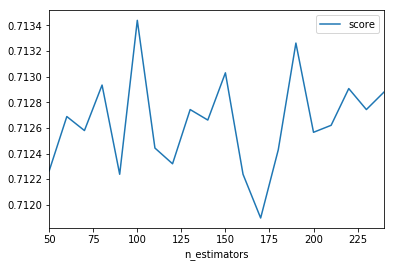

In [10]:
#now perform parameter tuning for Random Forest
#Begin with number of estimators


estimators = []
for i in range(50, 250, 10):

    clf = RandomForestClassifier(n_estimators=i) 
    scores = cross_val_score(estimator=clf, X = Xad, y = Yad, cv = 5, n_jobs = 4)
    estimators.append((i, scores.mean()))
print(estimators)
pd.DataFrame(estimators, columns = ['n_estimators', 'score']).set_index('n_estimators').plot()
#Not much difference in number of estimators. Use 50

[(80, 0.7165916169738372), (90, 0.7171237942859164), (100, 0.7174512763417764), (110, 0.7168235684979823), (120, 0.7173693418232525), (130, 0.7187475601348994), (140, 0.717464908663334), (150, 0.7182972363470086), (160, 0.7193616198289072), (170, 0.7168371738209622), (180, 0.7175740305598883), (190, 0.7169190543425847)]


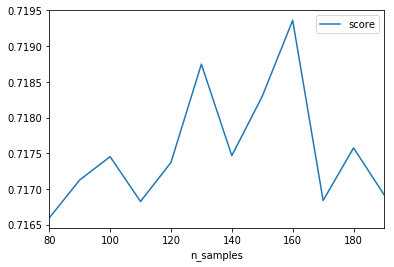

In [11]:
#Repeat for number of min samples
samples=[]
for i in range(80, 200, 10):

    clf = RandomForestClassifier(n_estimators=50, min_samples_split = i) 
    scores = cross_val_score(estimator=clf, X = Xad, y = Yad, cv = 5, n_jobs = 4)
    samples.append((i, scores.mean()))
print(samples)
pd.DataFrame(samples, columns = ['n_samples', 'score']).set_index('n_samples').plot()
#Best around 150

In [12]:
forest = RandomForestClassifier(n_estimators=50, min_samples_split = 150)

In [13]:
#Define logistic regression model (no tuning required)
logreg = LogisticRegression()

In [14]:
#Define a function that will run the selected model and output the measures
#of interest
def modelrun(model, xtrain, ytrain, xtest, ytest):
    start = time.time()
    model.fit(xtrain, ytrain)
    y_pred=model.predict(xtest)
    print(' ')
    
    print("Confusion Matrix:",metrics.confusion_matrix(ytest, y_pred))
    acc = metrics.accuracy_score(ytest, y_pred)
    prec = metrics.precision_score(ytest, y_pred)
    rec = metrics.recall_score(ytest, y_pred)
    print("Accuracy:",acc)
    print("Precision:",prec)
    print("Recall:",rec)
    y_pred_proba = model.predict_proba(xtest)[::,1]
    fpr, tpr, _ = metrics.roc_curve(ytest,  y_pred_proba)
    auc = metrics.roc_auc_score(ytest, y_pred_proba)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()
    print('MCC:')
    print(matthews_corrcoef(ytest, y_pred))
    mcc = matthews_corrcoef(ytest, y_pred)
    elapsed = time.time() - start
    print("Time to run",elapsed)
    return acc, prec, rec, auc, mcc

In [15]:
#Define functions that append outcome variables to lists so that analyses can
#be performed on the results

def logreg_append(modelrun):
    acc_logreg.append(modelrun[0])
    prec_logreg.append(modelrun[1])
    rec_logreg.append(modelrun[2])
    aur_logreg.append(modelrun[3])
    mcc_logreg.append(modelrun[4])
    
def tree_append(modelrun):
    acc_tree.append(modelrun[0])
    prec_tree.append(modelrun[1])
    rec_tree.append(modelrun[2])
    aur_tree.append(modelrun[3])
    mcc_tree.append(modelrun[4])

def boost_append(modelrun):
    acc_booster.append(modelrun[0])
    prec_booster.append(modelrun[1])
    rec_booster.append(modelrun[2])
    aur_booster.append(modelrun[3])
    mcc_booster.append(modelrun[4])
    
def forest_append(modelrun):
    acc_forest.append(modelrun[0])
    prec_forest.append(modelrun[1])
    rec_forest.append(modelrun[2])
    aur_forest.append(modelrun[3])
    mcc_forest.append(modelrun[4])


Logistic Regression 0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[8521 2269]
 [2723 4808]]
Accuracy: 0.7275257900769608
Precision: 0.6793839197400028
Recall: 0.6384278316292658


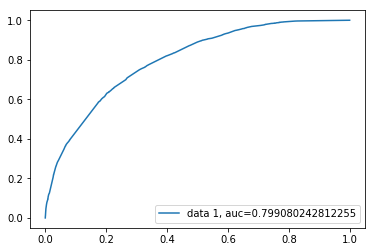

MCC:
0.43265165642363396
Time to run 0.4442000389099121

Decision Tree 0
 
Confusion Matrix: [[8253 2537]
 [2850 4681]]
Accuracy: 0.7059658315594127
Precision: 0.6485175949016349
Recall: 0.621564201301288


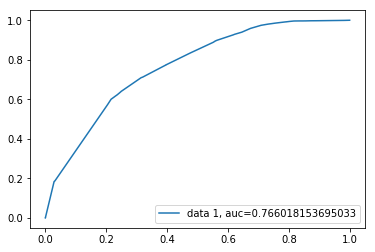

MCC:
0.38912531298840525
Time to run 0.46179986000061035

Boosted Trees 0
 
Confusion Matrix: [[8404 2386]
 [2622 4909]]
Accuracy: 0.7266524753015665
Precision: 0.672926662097327
Recall: 0.6518390651971849


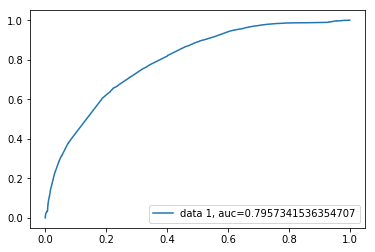

MCC:
0.43291111282239964
Time to run 7.3764002323150635

Random Forest 0
 
Confusion Matrix: [[8586 2204]
 [2732 4799]]
Accuracy: 0.7305823917908411
Precision: 0.6852777381122376
Recall: 0.6372327712123224


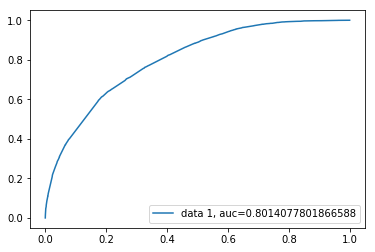

MCC:
0.4383969328103858
Time to run 5.686399936676025
Logistic Regression 1


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[8570 2253]
 [2702 4796]]
Accuracy: 0.7295453304950603
Precision: 0.68038019577245
Recall: 0.6396372365964257


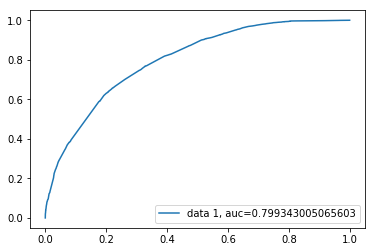

MCC:
0.43604604205650876
Time to run 0.43379974365234375

Decision Tree 1
 
Confusion Matrix: [[8299 2524]
 [2794 4704]]
Accuracy: 0.7097320015283008
Precision: 0.6508024349750968
Recall: 0.627367297946119


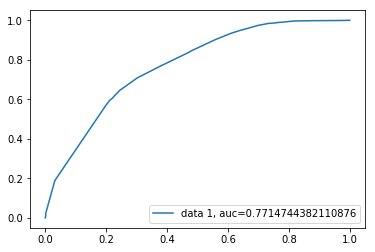

MCC:
0.3965388852116102
Time to run 0.432999849319458

Boosted Trees 1
 
Confusion Matrix: [[8536 2287]
 [2731 4767]]
Accuracy: 0.726106653566945
Precision: 0.6757867876382194
Recall: 0.6357695385436116


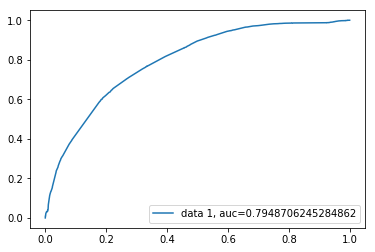

MCC:
0.42890562169996505
Time to run 7.140599966049194

Random Forest 1
 
Confusion Matrix: [[8626 2197]
 [2778 4720]]
Accuracy: 0.7284536870258174
Precision: 0.6823767529275697
Recall: 0.6295012003200854


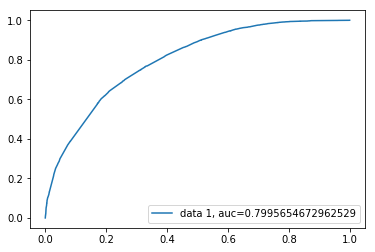

MCC:
0.4325992922927962
Time to run 5.642600059509277
Logistic Regression 2


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[8444 2235]
 [2767 4875]]
Accuracy: 0.7269799683423394
Precision: 0.6856540084388185
Recall: 0.6379220099450406


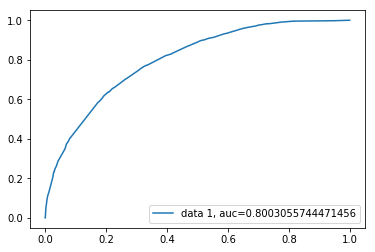

MCC:
0.43370775179940424
Time to run 0.5348000526428223

Decision Tree 2
 
Confusion Matrix: [[8258 2421]
 [2929 4713]]
Accuracy: 0.7079853719775121
Precision: 0.6606391925988225
Recall: 0.6167233708453285


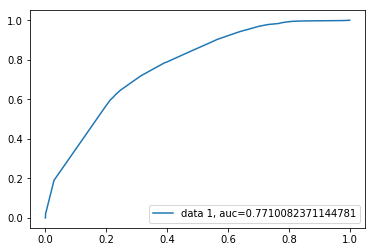

MCC:
0.39439254565776694
Time to run 0.5608000755310059

Boosted Trees 2
 
Confusion Matrix: [[8391 2288]
 [2713 4929]]
Accuracy: 0.7270345505158016
Precision: 0.6829707634751282
Recall: 0.644988222978278


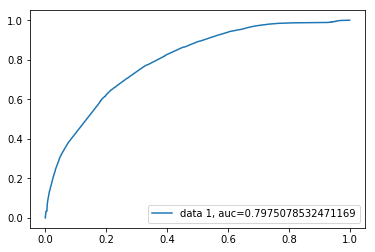

MCC:
0.4346721879417599
Time to run 7.24780011177063

Random Forest 2
 
Confusion Matrix: [[8566 2113]
 [2874 4768]]
Accuracy: 0.7277987009442716
Precision: 0.6929225403284406
Recall: 0.6239204396754776


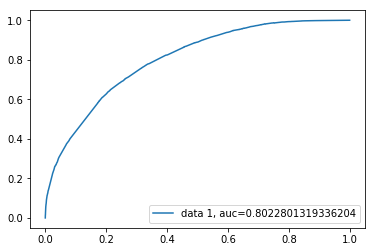

MCC:
0.4338066101395973
Time to run 5.538800001144409
Logistic Regression 3


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[8572 2210]
 [2768 4771]]
Accuracy: 0.7282899405054309
Precision: 0.6834264432029795
Recall: 0.6328425520626078


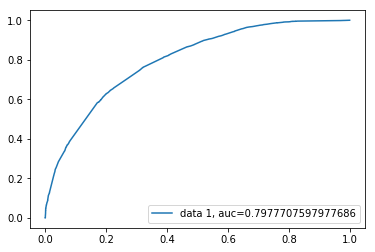

MCC:
0.43356513319854584
Time to run 0.44640016555786133

Decision Tree 3
 
Confusion Matrix: [[8246 2536]
 [2787 4752]]
Accuracy: 0.7094590906609901
Precision: 0.6520307354555434
Recall: 0.6303223239156387


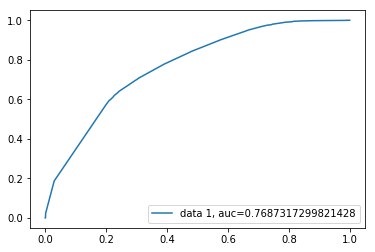

MCC:
0.3972643637496489
Time to run 0.44319987297058105

Boosted Trees 3
 
Confusion Matrix: [[8449 2333]
 [2709 4830]]
Accuracy: 0.7247966814038534
Precision: 0.6742984782912188
Recall: 0.6406685236768802


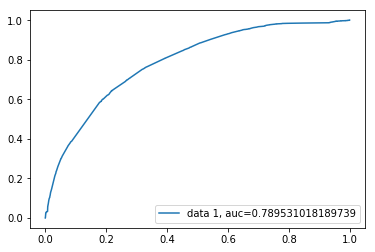

MCC:
0.42788595941220187
Time to run 7.311800003051758

Random Forest 3
 
Confusion Matrix: [[8615 2167]
 [2813 4726]]
Accuracy: 0.7281807761585066
Precision: 0.6856230958943856
Recall: 0.6268735906618915


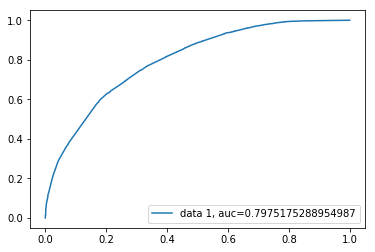

MCC:
0.4326285769978584
Time to run 6.270799875259399
Logistic Regression 4


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[8540 2250]
 [2714 4817]]
Accuracy: 0.729054090933901
Precision: 0.6816187915664356
Recall: 0.639622892046209


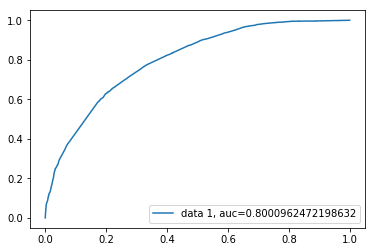

MCC:
0.4357531352242893
Time to run 0.5109999179840088

Decision Tree 4
 
Confusion Matrix: [[8171 2619]
 [2733 4798]]
Accuracy: 0.7078762076305879
Precision: 0.6468922745045167
Recall: 0.6370999867215509


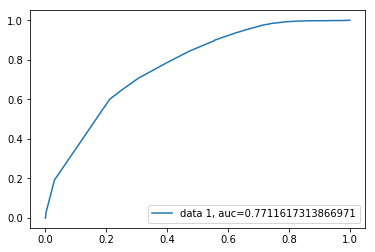

MCC:
0.3953116631804617
Time to run 0.4940001964569092

Boosted Trees 4
 
Confusion Matrix: [[8486 2304]
 [2690 4841]]
Accuracy: 0.7274166257300365
Precision: 0.6775367389783065
Recall: 0.6428097198247245


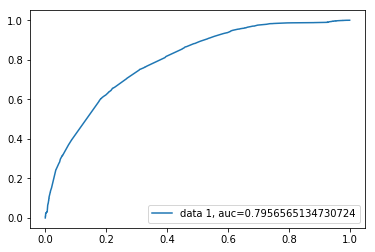

MCC:
0.4330440196950344
Time to run 7.781999826431274

Random Forest 4
 
Confusion Matrix: [[8621 2169]
 [2754 4777]]
Accuracy: 0.7312919600458491
Precision: 0.6877339475957386
Recall: 0.6343115124153499


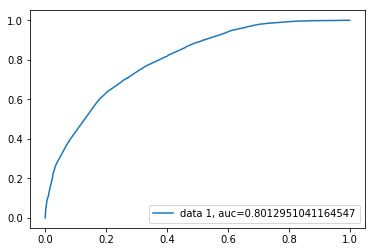

MCC:
0.43941479421513147
Time to run 6.513999700546265
Logistic Regression 5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[8678 2229]
 [2659 4755]]
Accuracy: 0.7332023361170242
Precision: 0.6808419243986255
Recall: 0.6413541947666577


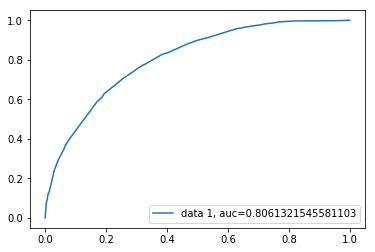

MCC:
0.44162055817818247
Time to run 0.516200065612793

Decision Tree 5
 
Confusion Matrix: [[8395 2512]
 [2784 4630]]
Accuracy: 0.7109328093444681
Precision: 0.6482777933352002
Recall: 0.624494200161856


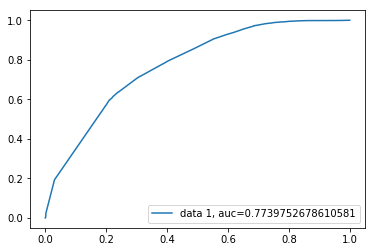

MCC:
0.3967033493296955
Time to run 0.5119998455047607

Boosted Trees 5
 
Confusion Matrix: [[8623 2284]
 [2652 4762]]
Accuracy: 0.7305823917908411
Precision: 0.6758444507521998
Recall: 0.6422983544645265


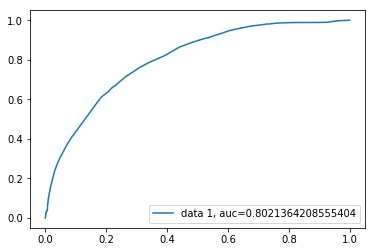

MCC:
0.43674552392877586
Time to run 8.055999994277954

Random Forest 5
 
Confusion Matrix: [[8708 2199]
 [2669 4745]]
Accuracy: 0.7342939795862671
Precision: 0.683323732718894
Recall: 0.6400053951982735


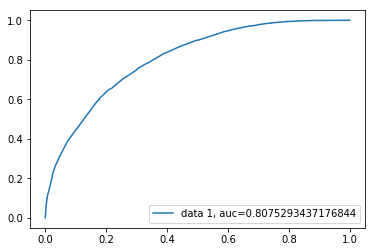

MCC:
0.4435295782448524
Time to run 6.212400197982788
Logistic Regression 6


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[8577 2212]
 [2753 4779]]
Accuracy: 0.7289995087604388
Precision: 0.6835931912458876
Recall: 0.6344928305894849


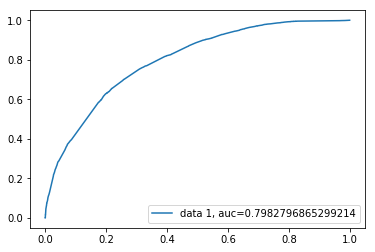

MCC:
0.4350039142220537
Time to run 0.503000020980835

Decision Tree 6
 
Confusion Matrix: [[8412 2377]
 [2874 4658]]
Accuracy: 0.7133890071502648
Precision: 0.6621179815209666
Recall: 0.6184280403611259


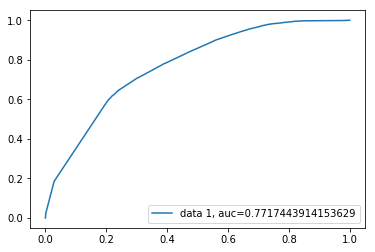

MCC:
0.4027614644947529
Time to run 0.5162003040313721

Boosted Trees 6
 
Confusion Matrix: [[8567 2222]
 [2743 4789]]
Accuracy: 0.7289995087604388
Precision: 0.6830694622735701
Recall: 0.6358204992033988


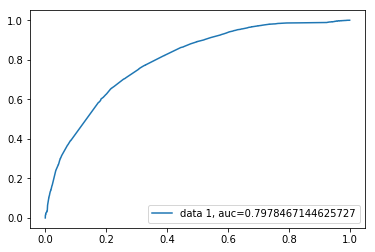

MCC:
0.43517265486723705
Time to run 7.590800046920776

Random Forest 6
 
Confusion Matrix: [[8759 2030]
 [2920 4612]]
Accuracy: 0.7298182413623711
Precision: 0.6943691659138813
Recall: 0.6123207647371216


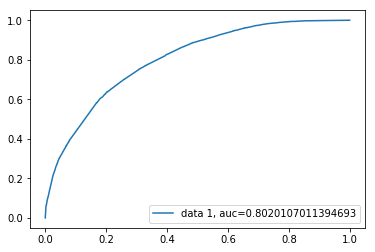

MCC:
0.43413970597984336
Time to run 5.507200002670288
Logistic Regression 7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[8614 2227]
 [2667 4813]]
Accuracy: 0.7328748430762513
Precision: 0.6836647727272728
Recall: 0.6434491978609626


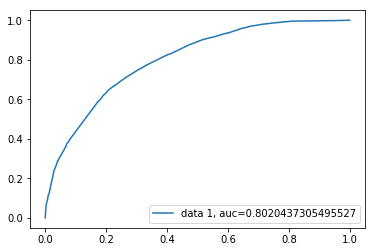

MCC:
0.44261342380738256
Time to run 0.4404001235961914

Decision Tree 7
 
Confusion Matrix: [[8324 2517]
 [2766 4714]]
Accuracy: 0.711642377599476
Precision: 0.6519153644032637
Recall: 0.6302139037433155


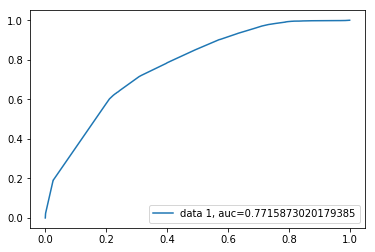

MCC:
0.4002643972582591
Time to run 0.4401998519897461

Boosted Trees 7
 
Confusion Matrix: [[8475 2366]
 [2586 4894]]
Accuracy: 0.7297090770154467
Precision: 0.6741046831955922
Recall: 0.6542780748663102


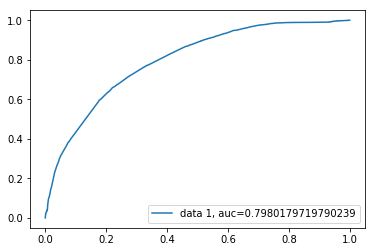

MCC:
0.43816617764387783
Time to run 7.396600008010864

Random Forest 7
 
Confusion Matrix: [[8595 2246]
 [2691 4789]]
Accuracy: 0.730527809617379
Precision: 0.6807391613361763
Recall: 0.64024064171123


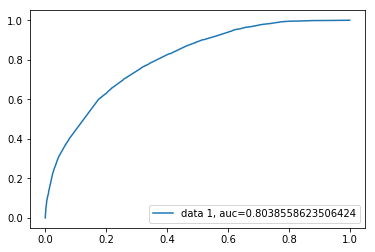

MCC:
0.43765879746002173
Time to run 5.693399906158447
Logistic Regression 8


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[8470 2298]
 [2699 4854]]
Accuracy: 0.7272528792096501
Precision: 0.6786912751677853
Recall: 0.6426585462730041


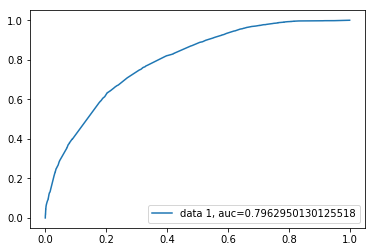

MCC:
0.43312683829491816
Time to run 0.4463999271392822

Decision Tree 8
 
Confusion Matrix: [[8207 2561]
 [2812 4741]]
Accuracy: 0.7067299819878827
Precision: 0.649274171459874
Recall: 0.6276976036012181


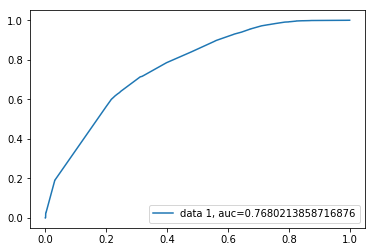

MCC:
0.39196527335327536
Time to run 0.430800199508667

Boosted Trees 8
 
Confusion Matrix: [[8420 2348]
 [2682 4871]]
Accuracy: 0.7254516674853992
Precision: 0.674747194902341
Recall: 0.6449093075599099


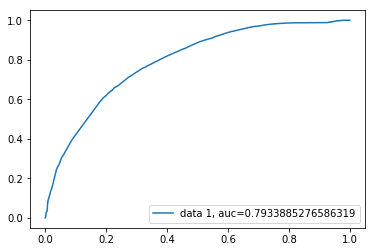

MCC:
0.43000087197567755
Time to run 7.164000034332275

Random Forest 8
 
Confusion Matrix: [[8532 2236]
 [2749 4804]]
Accuracy: 0.7279078652911959
Precision: 0.6823863636363636
Recall: 0.6360386601350457


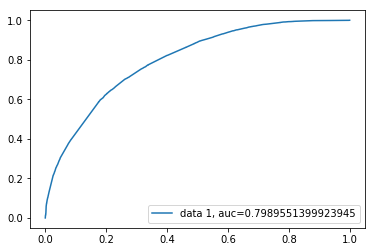

MCC:
0.4335136412438412
Time to run 5.731200218200684
Logistic Regression 9


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[8600 2255]
 [2650 4816]]
Accuracy: 0.7322744391681677
Precision: 0.6810917833404044
Recall: 0.645057594428074


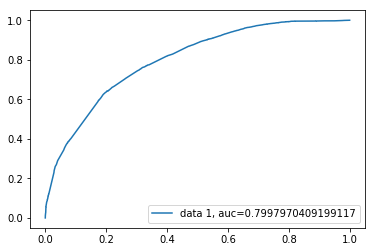

MCC:
0.4414086064522432
Time to run 0.43339991569519043

Decision Tree 9
 
Confusion Matrix: [[8296 2559]
 [2724 4742]]
Accuracy: 0.711642377599476
Precision: 0.6495000684837694
Recall: 0.6351459951781409


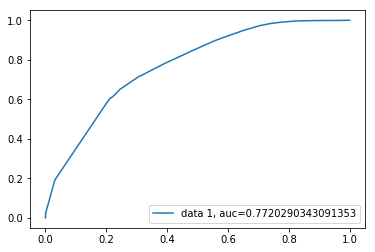

MCC:
0.40085497448419427
Time to run 0.44120025634765625

Boosted Trees 9
 
Confusion Matrix: [[8464 2391]
 [2561 4905]]
Accuracy: 0.7297090770154467
Precision: 0.6722861842105263
Recall: 0.6569783016340744


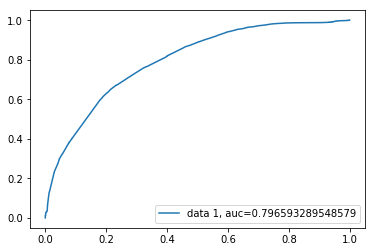

MCC:
0.43835046238670566
Time to run 7.153199672698975

Random Forest 9
 
Confusion Matrix: [[8594 2261]
 [2672 4794]]
Accuracy: 0.7307461383112276
Precision: 0.6795180722891566
Recall: 0.6421109027591749


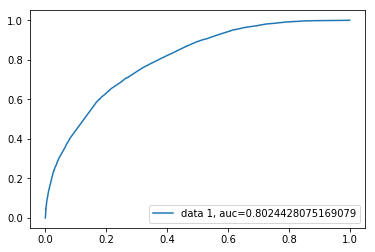

MCC:
0.4380612989982025
Time to run 5.755799770355225
Logistic Regression accuracy: [0.7275257900769608, 0.7295453304950603, 0.7269799683423394, 0.7282899405054309, 0.729054090933901, 0.7332023361170242, 0.7289995087604388, 0.7328748430762513, 0.7272528792096501, 0.7322744391681677] [<matplotlib.lines.Line2D object at 0x000000000CF72B70>]
Logistic Regression precision: [0.6793839197400028, 0.68038019577245, 0.6856540084388185, 0.6834264432029795, 0.6816187915664356, 0.6808419243986255, 0.6835931912458876, 0.6836647727272728, 0.6786912751677853, 0.6810917833404044] [<matplotlib.lines.Line2D object at 0x000000000CF72CF8>]
Logistic Regression recall: [0.6384278316292658, 0.6396372365964257, 0.6379220099450406, 0.6328425520626078, 0.639622892046209, 0.6413541947666577, 0.6344928305894849, 0.6434491978609626, 0.6426585462730041, 0.645057594428074] [<matplotlib.lines.Line2D object at 0x000000000CF6B128>]
Logistic Regression AUROC: [0.799080242812255, 0.799343005065603, 0.8003055744471456, 0.

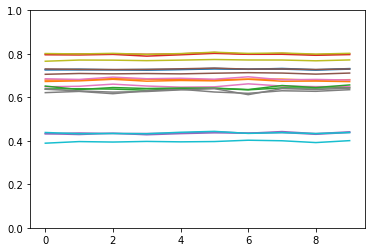

In [40]:
##Run through cross validation for initial models

acc_logreg = []
prec_logreg = []
rec_logreg = []
aur_logreg = []
mcc_logreg = []

acc_tree = []
prec_tree = []
rec_tree = []
aur_tree = []
mcc_tree = []

acc_booster = []
prec_booster = []
rec_booster = []
aur_booster = []
mcc_booster = []

acc_forest = []
prec_forest = []
rec_forest = []
aur_forest = []
mcc_forest = []


for i in range (0,10):
    X_train,X_test,y_train,y_test=train_test_split(Xad,Yad,test_size=0.25,random_state=i)
    print('Logistic Regression', i)
    logreg1 = modelrun(model =logreg, xtrain=X_train, ytrain=y_train, xtest = X_test, ytest=y_test)
    logreg_append(logreg1)
    print('')
    print('Decision Tree', i)
    tree1 = modelrun(model =clf_tree, xtrain=X_train, ytrain=y_train, xtest = X_test, ytest=y_test)
    tree_append(tree1)
    print('')
    print('Boosted Trees', i)
    boost1 = modelrun(model = booster, xtrain=X_train, ytrain=y_train, xtest = X_test, ytest=y_test)
    boost_append(boost1)
    print('')
    print('Random Forest', i)
    forest1 = modelrun(model =forest, xtrain=X_train, ytrain=y_train, xtest = X_test, ytest=y_test)
    forest_append(forest1)

print("Logistic Regression accuracy:",acc_logreg, plt.plot(acc_logreg, scaley=False))
print("Logistic Regression precision:",prec_logreg, plt.plot(prec_logreg, scaley=False))
print("Logistic Regression recall:",rec_logreg, plt.plot(rec_logreg, scaley=False))
print("Logistic Regression AUROC:",aur_logreg, plt.plot(aur_logreg, scaley=False))
print("Logistic Regression MCC:",mcc_logreg, plt.plot(mcc_logreg, scaley=False)) 

print("Tree Accuracy:",acc_tree, plt.plot(acc_tree, scaley=False))
print("Tree Precision:",prec_tree, plt.plot(prec_tree, scaley=False))
print("Tree Recall:",rec_tree, plt.plot(rec_tree, scaley=False))
print("Tree AUROC:",aur_tree, plt.plot(aur_tree, scaley=False))
print("Tree MCC:",mcc_tree, plt.plot(mcc_tree, scaley=False))

print("Boosted Tree Accuracy:",acc_booster, plt.plot(acc_booster, scaley=False))
print("Boosted Tree Precision:",prec_booster, plt.plot(prec_booster, scaley=False))
print("Boosted Tree Recall:",rec_booster, plt.plot(rec_booster, scaley=False))
print("Boosted Tree AUROC:",aur_booster, plt.plot(aur_booster, scaley=False))
print("Boosted Tree MCC:",mcc_booster, plt.plot(mcc_booster, scaley=False))

print("Forest Accuracy:",acc_forest, plt.plot(acc_forest, scaley=False))
print("Forect Precision:",prec_forest, plt.plot(prec_forest, scaley=False))
print("Forest Recall:",rec_forest, plt.plot(rec_forest, scaley=False))
print("Forest AUROC:",aur_forest, plt.plot(aur_forest, scaley=False))
print("Forest MCC:",mcc_forest, plt.plot(mcc_forest, scaley=False)) 

In [41]:
#Copy results to new lists so that code can be reused

lr_acc_orig = acc_logreg.copy()
lr_prec_orig = prec_logreg.copy()
lr_rec_orig = rec_logreg.copy()
lr_auroc_orig = aur_logreg.copy()
lr_mcc_orig = mcc_logreg.copy()

tree_acc_orig = acc_tree.copy()
tree_prec_orig = prec_tree.copy()
tree_rec_orig = rec_tree.copy()
tree_auroc_orig = aur_tree.copy()
tree_mcc_orig = mcc_tree.copy()

boost_acc_orig = acc_booster.copy()
boost_prec_orig = prec_booster.copy()
boost_rec_orig = rec_booster.copy()
boost_auroc_orig = aur_booster.copy()
pboost_mcc_orig = mcc_booster.copy()

forest_acc_orig = acc_forest.copy()
forest_prec_orig = prec_forest.copy()
forest_rec_orig = rec_forest.copy()
forest_auroc_orig = aur_forest.copy()
forest_mcc_orig = mcc_forest.copy()

In [18]:
##Now repeat entire process for second set of models (includes social data)
Xad2 = readmit_model2.drop(['readmit'], 1) #Features
Yad2 = readmit_model2['readmit'] #Target variable
Xad2.shape, Yad2.shape

((73283, 128), (73283,))

Logistic Regression 0
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



Confusion Matrix: [[9334 1456]
 [5182 2349]]
Accuracy: 0.6376835325582665
Precision: 0.6173455978975033
Recall: 0.3119107688222016


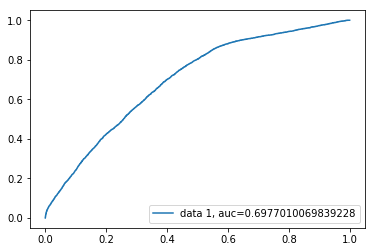

MCC:
0.21465369304889845
Time to run 0.4401998519897461

Decision Tree 0
 
Confusion Matrix: [[8720 2070]
 [2408 5123]]
Accuracy: 0.7555810272365046
Precision: 0.7122202140970388
Recall: 0.6802549462222812


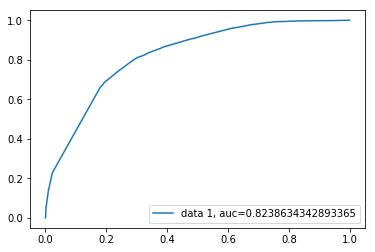

MCC:
0.49210590826736617
Time to run 0.6317999362945557

Boosted Trees 0
 
Confusion Matrix: [[8694 2096]
 [2238 5293]]
Accuracy: 0.7634408602150538
Precision: 0.7163350927053729
Recall: 0.7028283096534325


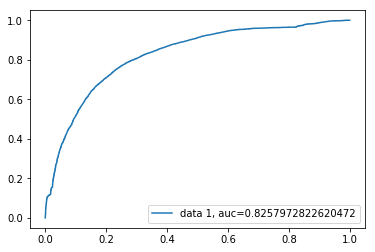

MCC:
0.5100924222280683
Time to run 9.772799968719482

Random Forest 0
 
Confusion Matrix: [[8892 1898]
 [2213 5318]]
Accuracy: 0.7756126848971125
Precision: 0.7369733924611973
Recall: 0.7061479219227195


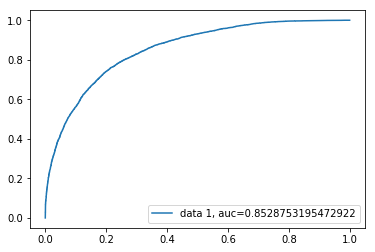

MCC:
0.5339560568121036
Time to run 6.338599920272827
Logistic Regression 1


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[9177 1646]
 [5023 2475]]
Accuracy: 0.63599148518094
Precision: 0.6005823829167678
Recall: 0.3300880234729261


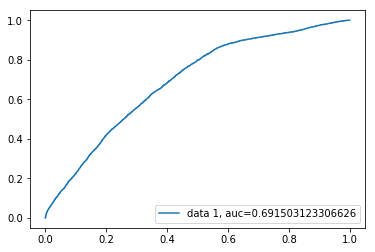

MCC:
0.20961967514150787
Time to run 0.4426002502441406

Decision Tree 1
 
Confusion Matrix: [[8510 2313]
 [2183 5315]]
Accuracy: 0.7545985481141859
Precision: 0.6967750393287887
Recall: 0.7088556948519605


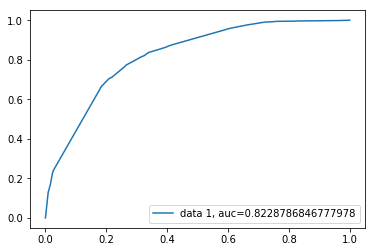

MCC:
0.4938818633984364
Time to run 0.6323997974395752

Boosted Trees 1
 
Confusion Matrix: [[8849 1974]
 [2300 5198]]
Accuracy: 0.7667157906227826
Precision: 0.7247629670942555
Recall: 0.6932515337423313


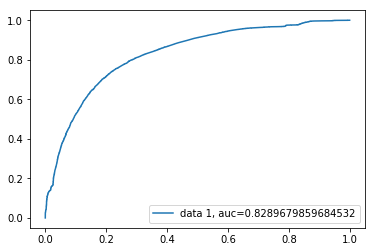

MCC:
0.5146502635130062
Time to run 10.087399959564209

Random Forest 1
 
Confusion Matrix: [[8901 1922]
 [2212 5286]]
Accuracy: 0.7743572949074832
Precision: 0.7333518312985572
Recall: 0.7049879967991465


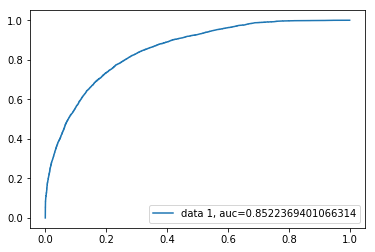

MCC:
0.530843227621797
Time to run 6.060999870300293
Logistic Regression 2


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[9203 1476]
 [5218 2424]]
Accuracy: 0.6346269308443863
Precision: 0.6215384615384615
Recall: 0.31719445171421096


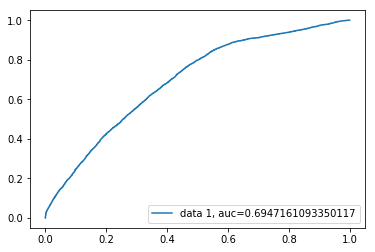

MCC:
0.2155964142413707
Time to run 0.42620015144348145

Decision Tree 2
 
Confusion Matrix: [[8532 2147]
 [2370 5272]]
Accuracy: 0.7534523224714809
Precision: 0.7106078986386305
Recall: 0.6898717613190264


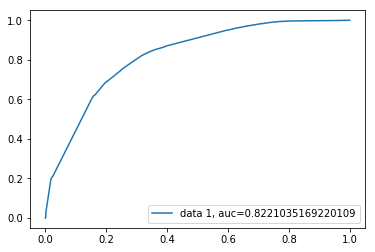

MCC:
0.491014869873832
Time to run 0.6689999103546143

Boosted Trees 2
 
Confusion Matrix: [[8717 1962]
 [2396 5246]]
Accuracy: 0.7621308880519623
Precision: 0.7278024417314095
Recall: 0.6864695105993196


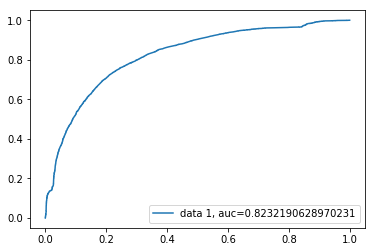

MCC:
0.5074497494532639
Time to run 10.37339997291565

Random Forest 2
 
Confusion Matrix: [[8783 1896]
 [2299 5343]]
Accuracy: 0.7710277823262922
Precision: 0.738085370907584
Recall: 0.6991625228997644


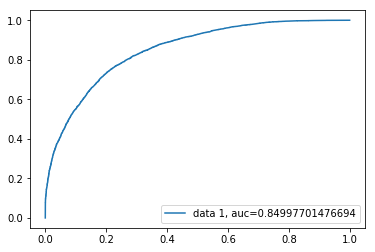

MCC:
0.5261055209201602
Time to run 5.729200124740601
Logistic Regression 3


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[9244 1538]
 [5127 2412]]
Accuracy: 0.6362098138747885
Precision: 0.610632911392405
Recall: 0.31993633107839237


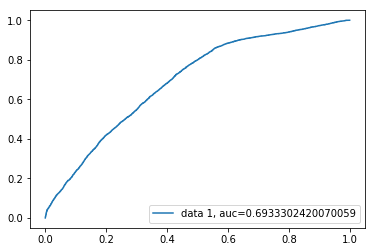

MCC:
0.21215419701132746
Time to run 0.4720001220703125

Decision Tree 3
 
Confusion Matrix: [[8685 2097]
 [2444 5095]]
Accuracy: 0.7521423503083893
Precision: 0.7084260289210234
Recall: 0.675819074147765


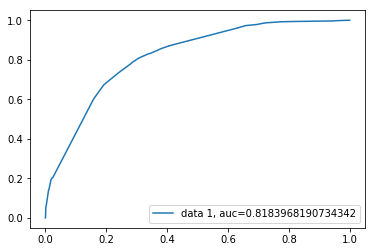

MCC:
0.48505946372779707
Time to run 0.63319993019104

Boosted Trees 3
 
Confusion Matrix: [[8780 2002]
 [2350 5189]]
Accuracy: 0.7624583810927351
Precision: 0.7215964399944375
Recall: 0.6882875712959279


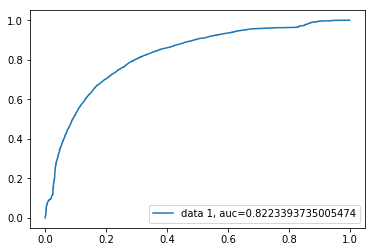

MCC:
0.5065163590830918
Time to run 10.751199960708618

Random Forest 3
 
Confusion Matrix: [[8851 1931]
 [2248 5291]]
Accuracy: 0.7719010971016866
Precision: 0.7326225422320687
Recall: 0.7018172171375514


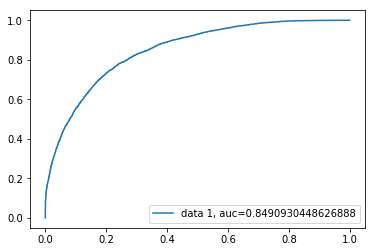

MCC:
0.5263892401287941
Time to run 5.841399908065796
Logistic Regression 4


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[9209 1581]
 [5163 2368]]
Accuracy: 0.6318978221712789
Precision: 0.5996454798683211
Recall: 0.31443367414685963


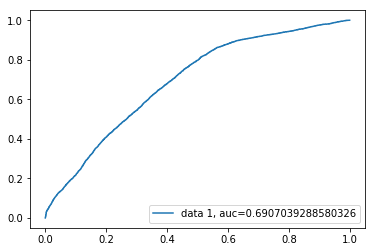

MCC:
0.20091351232870558
Time to run 0.45999979972839355

Decision Tree 4
 
Confusion Matrix: [[8747 2043]
 [2437 5094]]
Accuracy: 0.7554718628895802
Precision: 0.7137452711223203
Recall: 0.6764041959899084


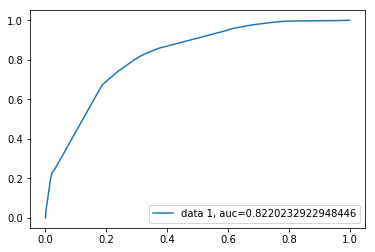

MCC:
0.49143383702830307
Time to run 0.6014001369476318

Boosted Trees 4
 
Confusion Matrix: [[8740 2050]
 [2264 5267]]
Accuracy: 0.7645325036842967
Precision: 0.7198305316386497
Recall: 0.6993759128933741


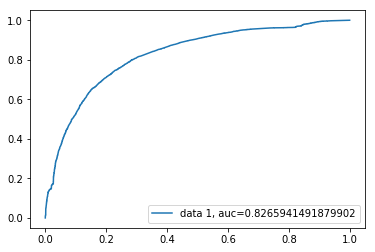

MCC:
0.5117307727282429
Time to run 10.917199850082397

Random Forest 4
 
Confusion Matrix: [[8848 1942]
 [2134 5397]]
Accuracy: 0.7775230609682877
Precision: 0.7353862924104101
Recall: 0.7166378966936662


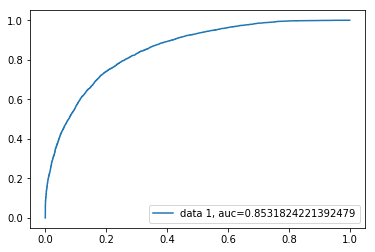

MCC:
0.538857859702716
Time to run 6.0320000648498535
Logistic Regression 5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[9359 1548]
 [4979 2435]]
Accuracy: 0.6437421538125648
Precision: 0.611348229977404
Recall: 0.32843269490153765


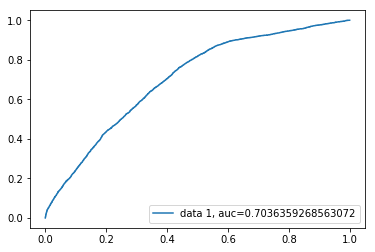

MCC:
0.22193261558599456
Time to run 0.3931999206542969

Decision Tree 5
 
Confusion Matrix: [[8732 2175]
 [2205 5209]]
Accuracy: 0.760930080235795
Precision: 0.7054442036836404
Recall: 0.7025896951712975


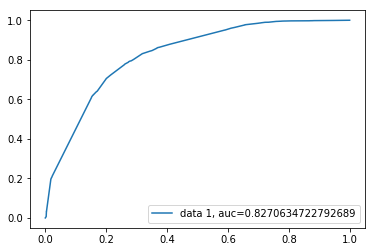

MCC:
0.5035056231281198
Time to run 0.6316001415252686

Boosted Trees 5
 
Confusion Matrix: [[8898 2009]
 [2180 5234]]
Accuracy: 0.7713552753670652
Precision: 0.7226287449951677
Recall: 0.7059616940922578


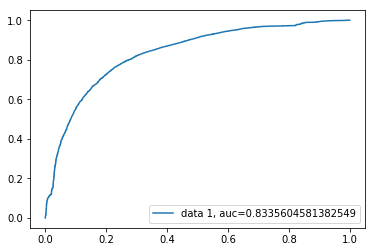

MCC:
0.523801227892404
Time to run 10.190999984741211

Random Forest 5
 
Confusion Matrix: [[9000 1907]
 [2127 5287]]
Accuracy: 0.7798155122536979
Precision: 0.7349179872115652
Recall: 0.7131103318046939


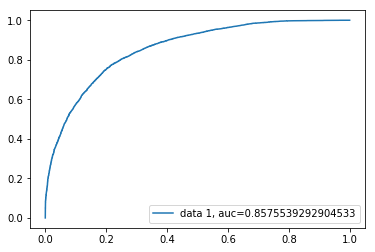

MCC:
0.5410079430924507
Time to run 5.9028003215789795
Logistic Regression 6


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[9226 1563]
 [5088 2444]]
Accuracy: 0.6369739643032586
Precision: 0.6099326179186424
Recall: 0.3244822092405735


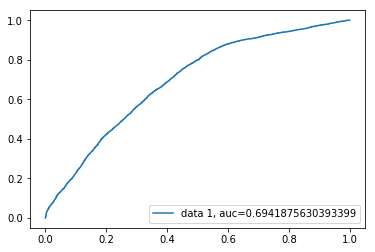

MCC:
0.2137922578692068
Time to run 0.45600008964538574

Decision Tree 6
 
Confusion Matrix: [[8533 2256]
 [2226 5306]]
Accuracy: 0.7553626985426559
Precision: 0.701666225866173
Recall: 0.7044609665427509


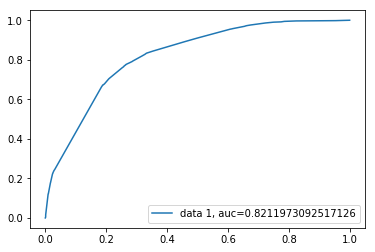

MCC:
0.49506430111539307
Time to run 0.5864002704620361

Boosted Trees 6
 
Confusion Matrix: [[8750 2039]
 [2221 5311]]
Accuracy: 0.7674799410512526
Precision: 0.7225850340136054
Recall: 0.705124800849708


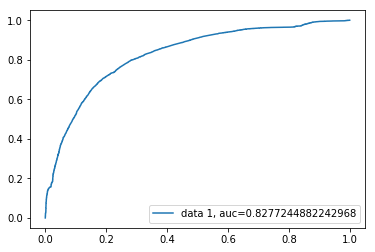

MCC:
0.5181352511328311
Time to run 10.180399894714355

Random Forest 6
 
Confusion Matrix: [[8871 1918]
 [2207 5325]]
Accuracy: 0.7748485344686425
Precision: 0.7351925997514842
Recall: 0.7069835369091875


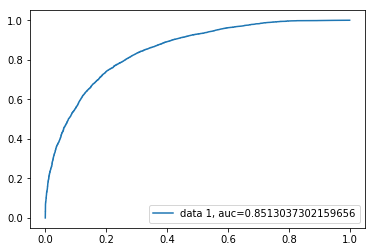

MCC:
0.5325786734790636
Time to run 5.773999929428101
Logistic Regression 7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[9174 1667]
 [5050 2430]]
Accuracy: 0.6333715408547569
Precision: 0.5931169148157188
Recall: 0.32486631016042783


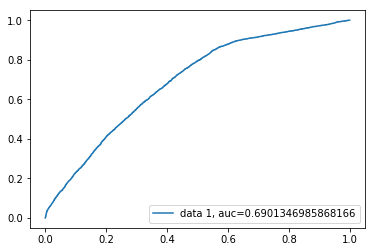

MCC:
0.20183063067410723
Time to run 0.4046001434326172

Decision Tree 7
 
Confusion Matrix: [[8645 2196]
 [2303 5177]]
Accuracy: 0.7544348015937995
Precision: 0.7021565170215651
Recall: 0.6921122994652407


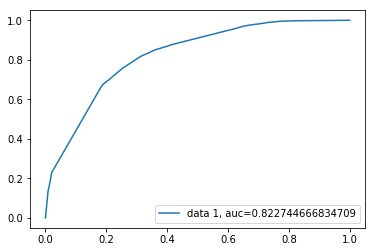

MCC:
0.4906719203112866
Time to run 0.6047999858856201

Boosted Trees 7
 
Confusion Matrix: [[8768 2073]
 [2278 5202]]
Accuracy: 0.7625129632661972
Precision: 0.7150515463917526
Recall: 0.6954545454545454


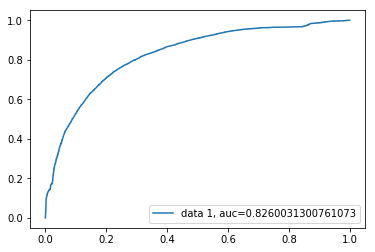

MCC:
0.5065243428661942
Time to run 10.041799783706665

Random Forest 7
 
Confusion Matrix: [[8946 1895]
 [2127 5353]]
Accuracy: 0.7804704983352437
Precision: 0.7385485651214128
Recall: 0.7156417112299466


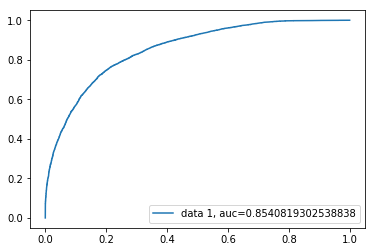

MCC:
0.5436437640611862
Time to run 5.950400114059448
Logistic Regression 8


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[9170 1598]
 [5111 2442]]
Accuracy: 0.633808198242454
Precision: 0.6044554455445544
Recall: 0.3233152389778896


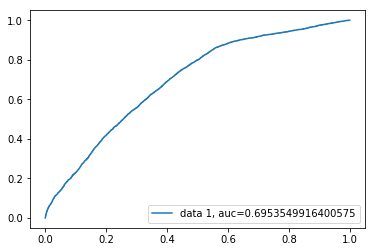

MCC:
0.2076721603043808
Time to run 0.4272000789642334

Decision Tree 8
 
Confusion Matrix: [[8491 2277]
 [2207 5346]]
Accuracy: 0.7552535341957317
Precision: 0.7012987012987013
Recall: 0.707798225870515


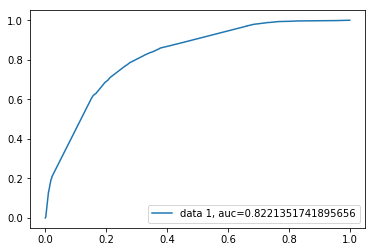

MCC:
0.49566794875555154
Time to run 0.6058001518249512

Boosted Trees 8
 
Confusion Matrix: [[8655 2113]
 [2190 5363]]
Accuracy: 0.7651329075923803
Precision: 0.7173622257891921
Recall: 0.7100489871574209


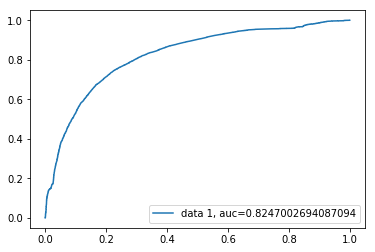

MCC:
0.5146220069970819
Time to run 9.708399772644043

Random Forest 8
 
Confusion Matrix: [[8825 1943]
 [2176 5377]]
Accuracy: 0.7751760275094154
Precision: 0.7345628415300547
Recall: 0.7119025552760493


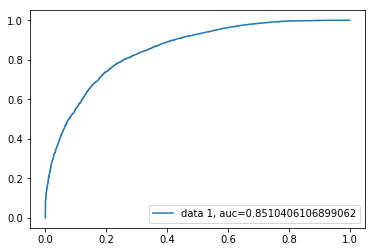

MCC:
0.5341049938086924
Time to run 5.479200124740601
Logistic Regression 9


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[9282 1573]
 [5039 2427]]
Accuracy: 0.6391026690682823
Precision: 0.60675
Recall: 0.3250736672917225


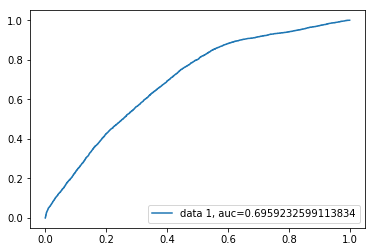

MCC:
0.21429351034823374
Time to run 0.3766000270843506

Decision Tree 9
 
Confusion Matrix: [[8411 2444]
 [2098 5368]]
Accuracy: 0.7520877681349272
Precision: 0.6871479774705581
Recall: 0.7189927672113582


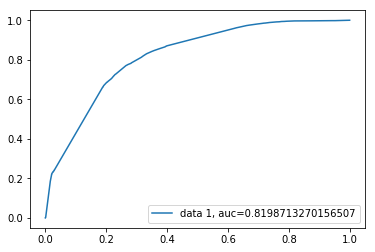

MCC:
0.4906661005048806
Time to run 0.7365996837615967

Boosted Trees 9
 
Confusion Matrix: [[8810 2045]
 [2234 5232]]
Accuracy: 0.7664428797554719
Precision: 0.7189776006596125
Recall: 0.7007768550763461


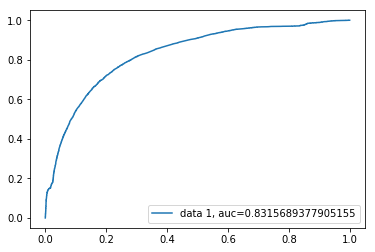

MCC:
0.5145355981838003
Time to run 9.630599975585938

Random Forest 9
 
Confusion Matrix: [[8907 1948]
 [2196 5270]]
Accuracy: 0.7738114731728617
Precision: 0.7301191465779995
Recall: 0.7058665952317171


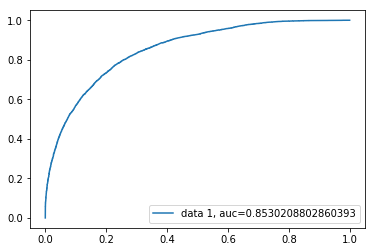

MCC:
0.5293641552666177
Time to run 5.430600166320801
Logistic Regression accuracy: [0.6376835325582665, 0.63599148518094, 0.6346269308443863, 0.6362098138747885, 0.6318978221712789, 0.6437421538125648, 0.6369739643032586, 0.6333715408547569, 0.633808198242454, 0.6391026690682823] [<matplotlib.lines.Line2D object at 0x000000000CE52A58>]
Logistic Regression precision: [0.6173455978975033, 0.6005823829167678, 0.6215384615384615, 0.610632911392405, 0.5996454798683211, 0.611348229977404, 0.6099326179186424, 0.5931169148157188, 0.6044554455445544, 0.60675] [<matplotlib.lines.Line2D object at 0x000000000CE52390>]
Logistic Regression recall: [0.3119107688222016, 0.3300880234729261, 0.31719445171421096, 0.31993633107839237, 0.31443367414685963, 0.32843269490153765, 0.3244822092405735, 0.32486631016042783, 0.3233152389778896, 0.3250736672917225] [<matplotlib.lines.Line2D object at 0x000000000CF09FD0>]
Logistic Regression AUROC: [0.6977010069839228, 0.691503123306626, 0.6947161093350117, 0.69333

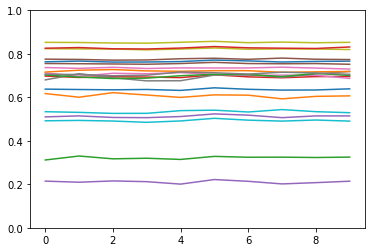

In [42]:
acc_logreg = []
prec_logreg = []
rec_logreg = []
aur_logreg = []
mcc_logreg = []

acc_tree = []
prec_tree = []
rec_tree = []
aur_tree = []
mcc_tree = []

acc_booster = []
prec_booster = []
rec_booster = []
aur_booster = []
mcc_booster = []

acc_forest = []
prec_forest = []
rec_forest = []
aur_forest = []
mcc_forest = []


for i in range (0,10):
    X_train2,X_test2,y_train2,y_test2=train_test_split(Xad2,Yad2,test_size=0.25,random_state=i)
    print('Logistic Regression', i)
    logreg1 = modelrun(model =logreg, xtrain=X_train2, ytrain=y_train2, xtest = X_test2, ytest=y_test2)
    logreg_append(logreg1)
    print('')
    print('Decision Tree', i)
    tree1 = modelrun(model =clf_tree, xtrain=X_train2, ytrain=y_train2, xtest = X_test2, ytest=y_test2)
    tree_append(tree1)
    print('')
    print('Boosted Trees', i)
    boost1 = modelrun(model = booster, xtrain=X_train2, ytrain=y_train2, xtest = X_test2, ytest=y_test2)
    boost_append(boost1)
    print('')
    print('Random Forest', i)
    forest1 = modelrun(model =forest, xtrain=X_train2, ytrain=y_train2, xtest = X_test2, ytest=y_test2)
    forest_append(forest1)
    
print("Logistic Regression accuracy:",acc_logreg, plt.plot(acc_logreg, scaley=False))
print("Logistic Regression precision:",prec_logreg, plt.plot(prec_logreg, scaley=False))
print("Logistic Regression recall:",rec_logreg, plt.plot(rec_logreg, scaley=False))
print("Logistic Regression AUROC:",aur_logreg, plt.plot(aur_logreg, scaley=False))
print("Logistic Regression MCC:",mcc_logreg, plt.plot(mcc_logreg, scaley=False)) 

print("Tree Accuracy:",acc_tree, plt.plot(acc_tree, scaley=False))
print("Tree Precision:",prec_tree, plt.plot(prec_tree, scaley=False))
print("Tree Recall:",rec_tree, plt.plot(rec_tree, scaley=False))
print("Tree AUROC:",aur_tree, plt.plot(aur_tree, scaley=False))
print("Tree MCC:",mcc_tree, plt.plot(mcc_tree, scaley=False))

print("Boosted Tree Accuracy:",acc_booster, plt.plot(acc_booster, scaley=False))
print("Boosted Tree Precision:",prec_booster, plt.plot(prec_booster, scaley=False))
print("Boosted Tree Recall:",rec_booster, plt.plot(rec_booster, scaley=False))
print("Boosted Tree AUROC:",aur_booster, plt.plot(aur_booster, scaley=False))
print("Boosted Tree MCC:",mcc_booster, plt.plot(mcc_booster, scaley=False))

print("Forest Accuracy:",acc_forest, plt.plot(acc_forest, scaley=False))
print("Forect Precision:",prec_forest, plt.plot(prec_forest, scaley=False))
print("Forest Recall:",rec_forest, plt.plot(rec_forest, scaley=False))
print("Forest AUROC:",aur_forest, plt.plot(aur_forest, scaley=False))
print("Forest MCC:",mcc_forest, plt.plot(mcc_forest, scaley=False)) 

In [43]:
lr_accuracy_social = acc_logreg.copy()
lr_prec_social = prec_logreg.copy()
lr_rec_social = rec_logreg.copy()
lr_auroc_social = aur_logreg.copy()
lr_mcc_social = mcc_logreg.copy()

tree_accuracy_social = acc_tree.copy()
tree_prec_social = prec_tree.copy()
tree_rec_social = rec_tree.copy()
tree_auroc_social = aur_tree.copy()
tree_mcc_social = mcc_tree.copy()

boost_acc_social = acc_booster.copy()
boost_prec_social = prec_booster.copy()
boost_rec_social = rec_booster.copy()
boost_auroc_social = aur_booster.copy()
pboost_mcc_social = mcc_booster.copy()

forest_acc_social = acc_forest.copy()
forest_prec_social = prec_forest.copy()
forest_rec_social = rec_forest.copy()
forest_auroc_social = aur_forest.copy()
forest_mcc_social = mcc_forest.copy()

In [44]:
##Test models with only one or the other of the social variables to determine importance
##Now repeat entire process for second set of models (includes social data)
vbd = readmit_model2.drop(columns = 'VALUE')
val = readmit_model2.drop(columns = 'visitbyday')

In [45]:
Xad3 = vbd.drop(['readmit'], 1) #Features
Yad3 = vbd['readmit'] #Target variable
Xad3.shape, Yad3.shape

((73283, 127), (73283,))

Logistic Regression 0
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



Confusion Matrix: [[9872  918]
 [5957 1574]]
Accuracy: 0.6247475574477376
Precision: 0.6316211878009631
Recall: 0.2090027884743062


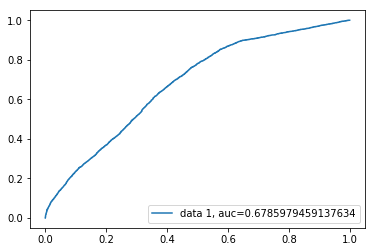

MCC:
0.17786551416198684
Time to run 0.4455997943878174

Decision Tree 0
 
Confusion Matrix: [[8748 2042]
 [2458 5073]]
Accuracy: 0.7543802194203373
Precision: 0.7130007027406887
Recall: 0.6736157216837073


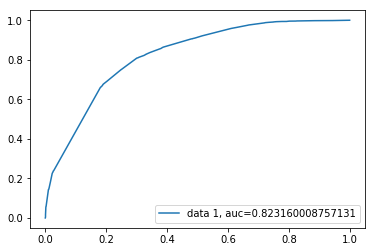

MCC:
0.4889881209234027
Time to run 0.6718001365661621

Boosted Trees 0
 
Confusion Matrix: [[8713 2077]
 [2288 5243]]
Accuracy: 0.7617488128377272
Precision: 0.7162568306010929
Recall: 0.6961890851148586


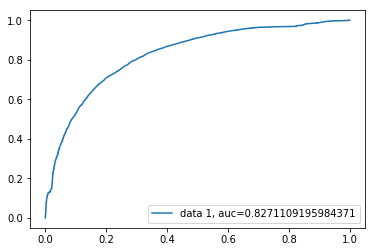

MCC:
0.5059807055705416
Time to run 9.335999965667725

Random Forest 0
 
Confusion Matrix: [[8913 1877]
 [2258 5273]]
Accuracy: 0.7743027127340211
Precision: 0.7374825174825175
Recall: 0.7001726198380029


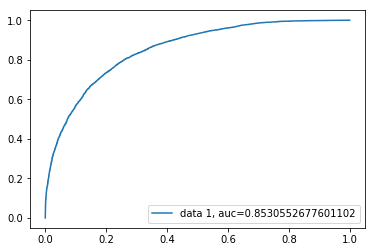

MCC:
0.5307639664166258
Time to run 5.936000108718872
Logistic Regression 1


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[9794 1029]
 [5912 1586]]
Accuracy: 0.6211451339992359
Precision: 0.6065009560229445
Recall: 0.2115230728194185


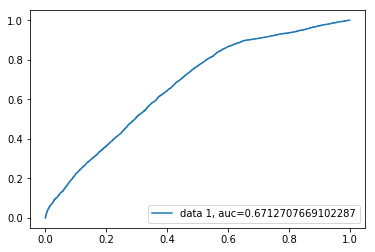

MCC:
0.16368507474601282
Time to run 0.49379992485046387

Decision Tree 1
 
Confusion Matrix: [[8736 2087]
 [2431 5067]]
Accuracy: 0.7533977402980186
Precision: 0.7082750908582611
Recall: 0.6757802080554814


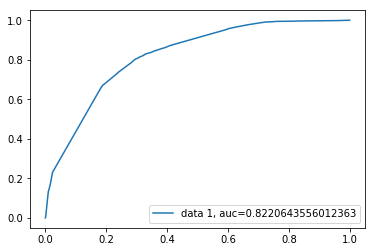

MCC:
0.4867501602577246
Time to run 0.704200029373169

Boosted Trees 1
 
Confusion Matrix: [[8838 1985]
 [2264 5234]]
Accuracy: 0.7680803449593363
Precision: 0.7250311677517661
Recall: 0.6980528140837556


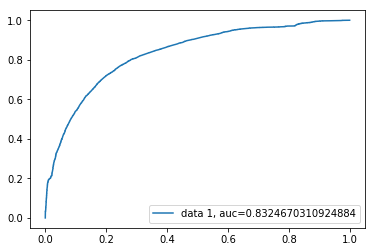

MCC:
0.5178654626828979
Time to run 9.610599994659424

Random Forest 1
 
Confusion Matrix: [[8955 1868]
 [2264 5234]]
Accuracy: 0.7744664592544075
Precision: 0.7369754998591946
Recall: 0.6980528140837556


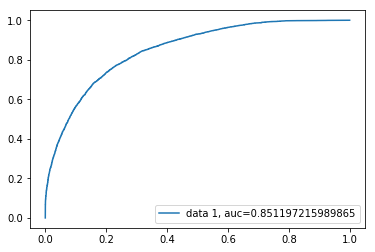

MCC:
0.5302939404595491
Time to run 6.217200040817261
Logistic Regression 2


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[9746  933]
 [6023 1619]]
Accuracy: 0.6203264013973037
Precision: 0.6344043887147336
Recall: 0.21185553520020936


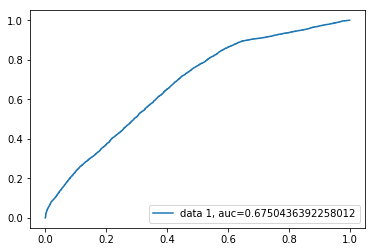

MCC:
0.17727733106627627
Time to run 0.40199971199035645

Decision Tree 2
 
Confusion Matrix: [[8626 2053]
 [2473 5169]]
Accuracy: 0.7529610829103215
Precision: 0.7157297147604542
Recall: 0.6763936142371108


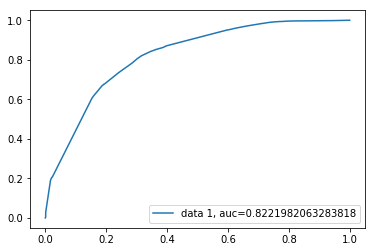

MCC:
0.488512320330285
Time to run 0.5778000354766846

Boosted Trees 2
 
Confusion Matrix: [[8652 2027]
 [2409 5233]]
Accuracy: 0.7578734785219148
Precision: 0.7207988980716253
Recall: 0.6847683852394661


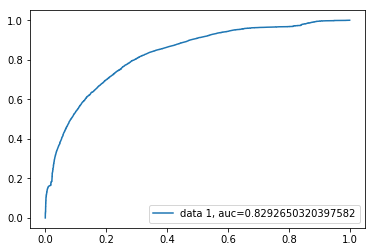

MCC:
0.4989653959286045
Time to run 9.710800170898438

Random Forest 2
 
Confusion Matrix: [[8810 1869]
 [2393 5249]]
Accuracy: 0.7673707767043284
Precision: 0.7374262433267772
Recall: 0.6868620779900549


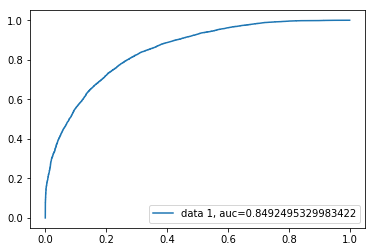

MCC:
0.5177995889683938
Time to run 6.1793999671936035
Logistic Regression 3


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[9809  973]
 [5963 1576]]
Accuracy: 0.6214180448665466
Precision: 0.6182816790898391
Recall: 0.20904629261175223


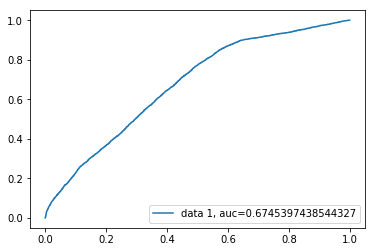

MCC:
0.16892997566047593
Time to run 0.4199998378753662

Decision Tree 3
 
Confusion Matrix: [[8706 2076]
 [2459 5080]]
Accuracy: 0.7524698433491621
Precision: 0.7098937954164337
Recall: 0.6738294203475262


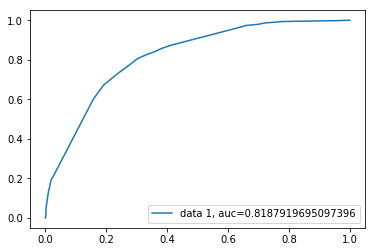

MCC:
0.48545111044270595
Time to run 0.6519999504089355

Boosted Trees 3
 
Confusion Matrix: [[8783 1999]
 [2332 5207]]
Accuracy: 0.7636046067354402
Precision: 0.7225922842076048
Recall: 0.6906751558562143


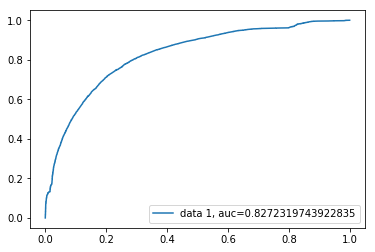

MCC:
0.5090157805082839
Time to run 10.064799785614014

Random Forest 3
 
Confusion Matrix: [[8909 1873]
 [2360 5179]]
Accuracy: 0.7689536597347306
Precision: 0.7344015882019286
Recall: 0.686961135429102


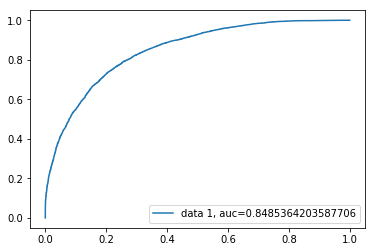

MCC:
0.5190784509261779
Time to run 6.006400108337402
Logistic Regression 4


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[9792  998]
 [6008 1523]]
Accuracy: 0.6175972927241963
Precision: 0.6041253470844903
Recall: 0.20223077944496082


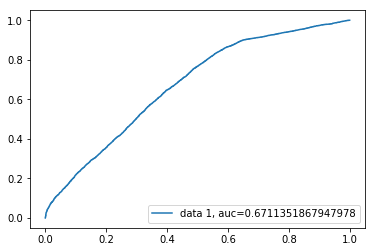

MCC:
0.1567393543229201
Time to run 0.37039995193481445

Decision Tree 4
 
Confusion Matrix: [[8743 2047]
 [2436 5095]]
Accuracy: 0.7553081163691938
Precision: 0.7133856062727527
Recall: 0.6765369804806799


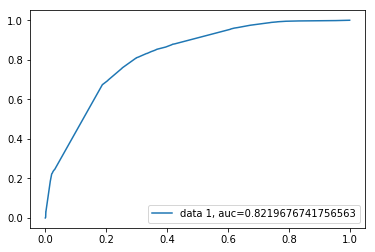

MCC:
0.4911316005046219
Time to run 0.5582001209259033

Boosted Trees 4
 
Confusion Matrix: [[8738 2052]
 [2267 5264]]
Accuracy: 0.764259592816986
Precision: 0.7195188627665391
Recall: 0.6989775594210597


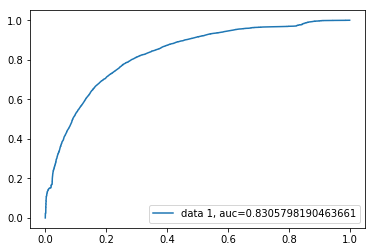

MCC:
0.5111560813384047
Time to run 9.530800104141235

Random Forest 4
 
Confusion Matrix: [[8881 1909]
 [2238 5293]]
Accuracy: 0.7736477266524753
Precision: 0.7349347403499028
Recall: 0.7028283096534325


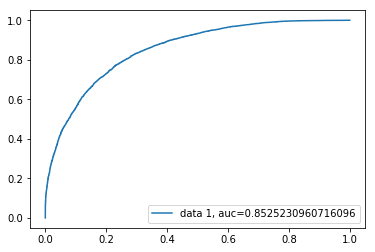

MCC:
0.5297672593593907
Time to run 5.9191999435424805
Logistic Regression 5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[9952  955]
 [5833 1581]]
Accuracy: 0.6294962065389443
Precision: 0.623422712933754
Recall: 0.21324521176153224


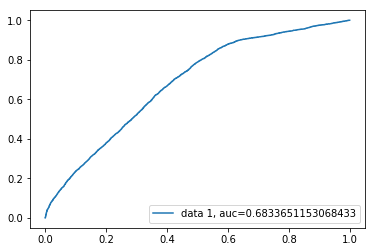

MCC:
0.1786370635840891
Time to run 0.3634002208709717

Decision Tree 5
 
Confusion Matrix: [[8778 2129]
 [2250 5164]]
Accuracy: 0.7609846624092571
Precision: 0.7080762374880022
Recall: 0.6965200971135689


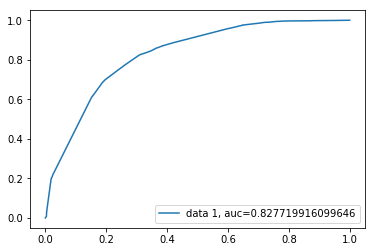

MCC:
0.5026853891731239
Time to run 0.559999942779541

Boosted Trees 5
 
Confusion Matrix: [[8856 2051]
 [2198 5216]]
Accuracy: 0.7680803449593363
Precision: 0.7177652401265997
Recall: 0.7035338548691664


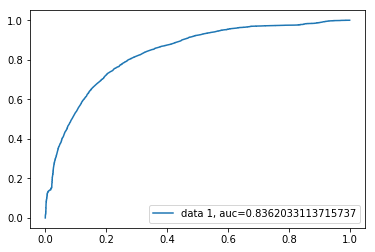

MCC:
0.517203486305459
Time to run 9.23740029335022

Random Forest 5
 
Confusion Matrix: [[9063 1844]
 [2210 5204]]
Accuracy: 0.778723868784455
Precision: 0.7383654937570943
Recall: 0.7019152953871055


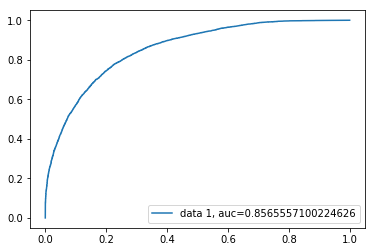

MCC:
0.5375648405219204
Time to run 5.915399789810181
Logistic Regression 6


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[9808  981]
 [5965 1567]]
Accuracy: 0.6208722231319251
Precision: 0.6149921507064364
Recall: 0.20804567180031863


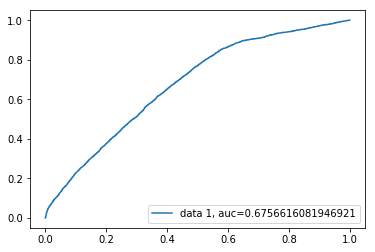

MCC:
0.16654014807677622
Time to run 0.377000093460083

Decision Tree 6
 
Confusion Matrix: [[8717 2072]
 [2444 5088]]
Accuracy: 0.753506904644943
Precision: 0.7106145251396648
Recall: 0.6755177907594264


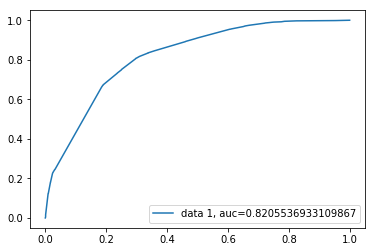

MCC:
0.48753693038322204
Time to run 0.557999849319458

Boosted Trees 6
 
Confusion Matrix: [[8757 2032]
 [2276 5256]]
Accuracy: 0.7648599967250695
Precision: 0.721185510428101
Recall: 0.6978226234731811


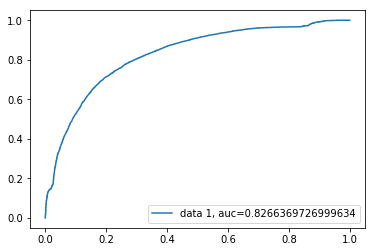

MCC:
0.512181818950099
Time to run 9.219600200653076

Random Forest 6
 
Confusion Matrix: [[8908 1881]
 [2261 5271]]
Accuracy: 0.773920637519786
Precision: 0.736996644295302
Recall: 0.699814126394052


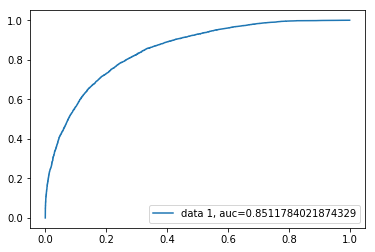

MCC:
0.5299961158392011
Time to run 5.941800117492676
Logistic Regression 7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[9816 1025]
 [5904 1576]]
Accuracy: 0.6218001200807817
Precision: 0.605920799692426
Recall: 0.2106951871657754


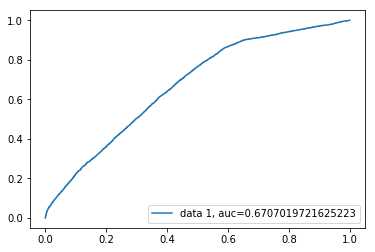

MCC:
0.16356709882191586
Time to run 0.3959999084472656

Decision Tree 7
 
Confusion Matrix: [[8790 2051]
 [2435 5045]]
Accuracy: 0.7551443698488074
Precision: 0.7109639233370914
Recall: 0.6744652406417112


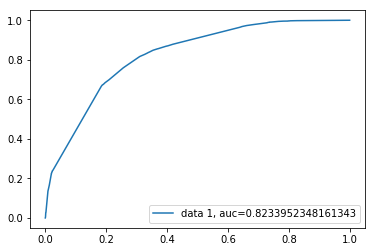

MCC:
0.4896371395693062
Time to run 0.5566000938415527

Boosted Trees 7
 
Confusion Matrix: [[8806 2035]
 [2299 5181]]
Accuracy: 0.7634408602150538
Precision: 0.7179878048780488
Recall: 0.6926470588235294


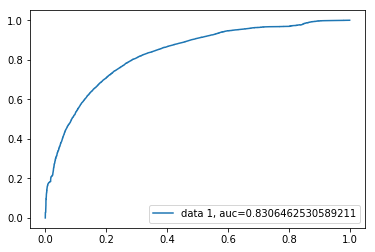

MCC:
0.5079398963722901
Time to run 9.280800104141235

Random Forest 7
 
Confusion Matrix: [[8949 1892]
 [2206 5274]]
Accuracy: 0.7763222531521206
Precision: 0.7359754395757745
Recall: 0.7050802139037433


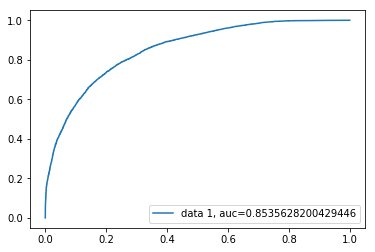

MCC:
0.5343733560812756
Time to run 5.915800094604492
Logistic Regression 8


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[9823  945]
 [5961 1592]]
Accuracy: 0.623055510070411
Precision: 0.6275128104059914
Recall: 0.21077717463259632


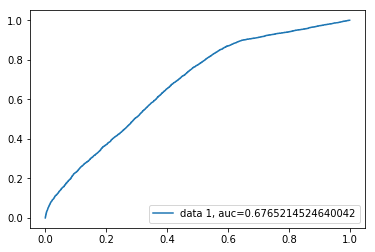

MCC:
0.17531704397337888
Time to run 0.3824000358581543

Decision Tree 8
 
Confusion Matrix: [[8640 2128]
 [2363 5190]]
Accuracy: 0.7548714589814967
Precision: 0.7092101667122165
Recall: 0.6871441811200847


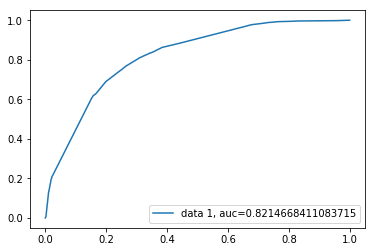

MCC:
0.4919799030555434
Time to run 0.5550000667572021

Boosted Trees 8
 
Confusion Matrix: [[8676 2092]
 [2223 5330]]
Accuracy: 0.7644779215108346
Precision: 0.718135273511183
Recall: 0.7056798623063684


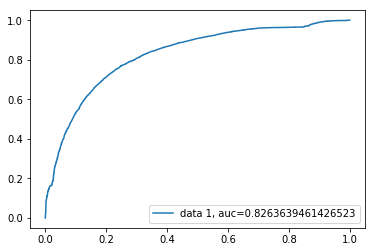

MCC:
0.5127841897354463
Time to run 9.474200248718262

Random Forest 8
 
Confusion Matrix: [[8891 1877]
 [2280 5273]]
Accuracy: 0.7731019049178538
Precision: 0.7374825174825175
Recall: 0.6981331921090957


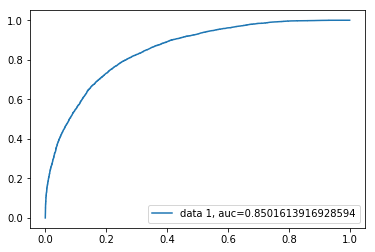

MCC:
0.5285798922061592
Time to run 6.315599679946899
Logistic Regression 9


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[9869  986]
 [5904 1562]]
Accuracy: 0.6239288248458054
Precision: 0.6130298273155416
Recall: 0.20921510849182962


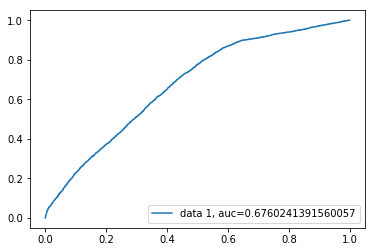

MCC:
0.16810687812095074
Time to run 0.3689999580383301

Decision Tree 9
 
Confusion Matrix: [[8614 2241]
 [2286 5180]]
Accuracy: 0.7529065007368594
Precision: 0.6980191348874815
Recall: 0.693811947495312


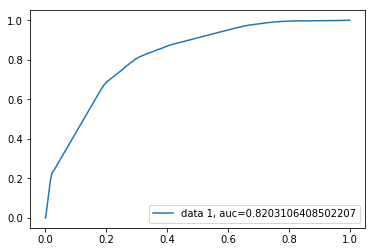

MCC:
0.487828613156417
Time to run 0.5449998378753662

Boosted Trees 9
 
Confusion Matrix: [[8858 1997]
 [2295 5171]]
Accuracy: 0.765733311500464
Precision: 0.7214006696428571
Recall: 0.6926064827216716


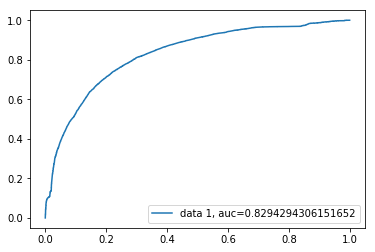

MCC:
0.5121192729157746
Time to run 9.255000114440918

Random Forest 9
 
Confusion Matrix: [[8928 1927]
 [2251 5215]]
Accuracy: 0.7719556792751487
Precision: 0.7301876225147018
Recall: 0.6984998660594696


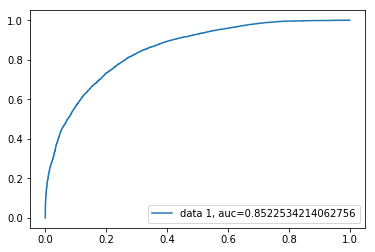

MCC:
0.5248882837576908
Time to run 6.581999778747559
Logistic Regression accuracy: [0.6247475574477376, 0.6211451339992359, 0.6203264013973037, 0.6214180448665466, 0.6175972927241963, 0.6294962065389443, 0.6208722231319251, 0.6218001200807817, 0.623055510070411, 0.6239288248458054] [<matplotlib.lines.Line2D object at 0x000000000CDE8860>]
Logistic Regression precision: [0.6316211878009631, 0.6065009560229445, 0.6344043887147336, 0.6182816790898391, 0.6041253470844903, 0.623422712933754, 0.6149921507064364, 0.605920799692426, 0.6275128104059914, 0.6130298273155416] [<matplotlib.lines.Line2D object at 0x000000000CDE89E8>]
Logistic Regression recall: [0.2090027884743062, 0.2115230728194185, 0.21185553520020936, 0.20904629261175223, 0.20223077944496082, 0.21324521176153224, 0.20804567180031863, 0.2106951871657754, 0.21077717463259632, 0.20921510849182962] [<matplotlib.lines.Line2D object at 0x000000000CDE8DD8>]
Logistic Regression AUROC: [0.6785979459137634, 0.6712707669102287, 0.675043639

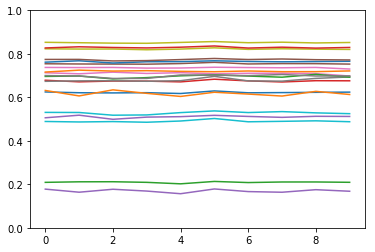

In [46]:
acc_logreg = []
prec_logreg = []
rec_logreg = []
aur_logreg = []
mcc_logreg = []

acc_tree = []
prec_tree = []
rec_tree = []
aur_tree = []
mcc_tree = []

acc_booster = []
prec_booster = []
rec_booster = []
aur_booster = []
mcc_booster = []

acc_forest = []
prec_forest = []
rec_forest = []
aur_forest = []
mcc_forest = []

for i in range (0,10):
    X_train2,X_test2,y_train2,y_test2=train_test_split(Xad3,Yad3,test_size=0.25,random_state=i)
    print('Logistic Regression', i)
    logreg1 = modelrun(model =logreg, xtrain=X_train2, ytrain=y_train2, xtest = X_test2, ytest=y_test2)
    logreg_append(logreg1)
    print('')
    print('Decision Tree', i)
    tree1 = modelrun(model =clf_tree, xtrain=X_train2, ytrain=y_train2, xtest = X_test2, ytest=y_test2)
    tree_append(tree1)
    print('')
    print('Boosted Trees', i)
    boost1 = modelrun(model = booster, xtrain=X_train2, ytrain=y_train2, xtest = X_test2, ytest=y_test2)
    boost_append(boost1)
    print('')
    print('Random Forest', i)
    forest1 = modelrun(model =forest, xtrain=X_train2, ytrain=y_train2, xtest = X_test2, ytest=y_test2)
    forest_append(forest1)
    

print("Logistic Regression accuracy:",acc_logreg, plt.plot(acc_logreg, scaley=False))
print("Logistic Regression precision:",prec_logreg, plt.plot(prec_logreg, scaley=False))
print("Logistic Regression recall:",rec_logreg, plt.plot(rec_logreg, scaley=False))
print("Logistic Regression AUROC:",aur_logreg, plt.plot(aur_logreg, scaley=False))
print("Logistic Regression MCC:",mcc_logreg, plt.plot(mcc_logreg, scaley=False)) 

print("Tree Accuracy:",acc_tree, plt.plot(acc_tree, scaley=False))
print("Tree Precision:",prec_tree, plt.plot(prec_tree, scaley=False))
print("Tree Recall:",rec_tree, plt.plot(rec_tree, scaley=False))
print("Tree AUROC:",aur_tree, plt.plot(aur_tree, scaley=False))
print("Tree MCC:",mcc_tree, plt.plot(mcc_tree, scaley=False))

print("Boosted Tree Accuracy:",acc_booster, plt.plot(acc_booster, scaley=False))
print("Boosted Tree Precision:",prec_booster, plt.plot(prec_booster, scaley=False))
print("Boosted Tree Recall:",rec_booster, plt.plot(rec_booster, scaley=False))
print("Boosted Tree AUROC:",aur_booster, plt.plot(aur_booster, scaley=False))
print("Boosted Tree MCC:",mcc_booster, plt.plot(mcc_booster, scaley=False))

print("Forest Accuracy:",acc_forest, plt.plot(acc_forest, scaley=False))
print("Forect Precision:",prec_forest, plt.plot(prec_forest, scaley=False))
print("Forest Recall:",rec_forest, plt.plot(rec_forest, scaley=False))
print("Forest AUROC:",aur_forest, plt.plot(aur_forest, scaley=False))
print("Forest MCC:",mcc_forest, plt.plot(mcc_forest, scaley=False)) 

In [47]:
lr_accuracy_vbd = acc_logreg.copy()
lr_prec_vbd = prec_logreg.copy()
lr_rec_vbd = rec_logreg.copy()
lr_auroc_vbd = aur_logreg.copy()
lr_mcc_vbd = mcc_logreg.copy()

tree_accuracy_vbd = acc_tree.copy()
tree_prec_vbd = prec_tree.copy()
tree_rec_vbd = rec_tree.copy()
tree_auroc_vbd = aur_tree.copy()
tree_mcc_vbd = mcc_tree.copy()

boost_acc_vbd = acc_booster.copy()
boost_prec_vbd = prec_booster.copy()
boost_rec_vbd = rec_booster.copy()
boost_auroc_vbd = aur_booster.copy()
pboost_mcc_vbd = mcc_booster.copy()

forest_acc_vbd = acc_forest.copy()
forest_prec_vbd = prec_forest.copy()
forest_rec_vbd = rec_forest.copy()
forest_auroc_vbd = aur_forest.copy()
forest_mcc_vbd = mcc_forest.copy()

In [48]:
Xad4 = val.drop(['readmit'], 1) #Features
Yad4 = val['readmit'] #Target variable
Xad4.shape, Yad4.shape


((73283, 127), (73283,))

Logistic Regression 0
 
Confusion Matrix: 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[9794  996]
 [5914 1617]]
Accuracy: 0.6228371813765624
Precision: 0.618828932261768
Recall: 0.21471252157747975


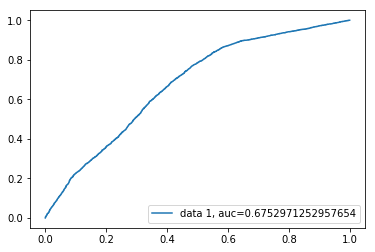

MCC:
0.17222866984499421
Time to run 0.37560009956359863

Decision Tree 0
 
Confusion Matrix: [[8650 2140]
 [2369 5162]]
Accuracy: 0.753888979859178
Precision: 0.7069296083264859
Recall: 0.6854335413623689


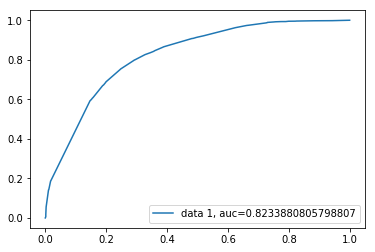

MCC:
0.48951356659807893
Time to run 0.6110000610351562

Boosted Trees 0
 
Confusion Matrix: [[8678 2112]
 [2259 5272]]
Accuracy: 0.7614213197969543
Precision: 0.71397616468039
Recall: 0.7000398353472315


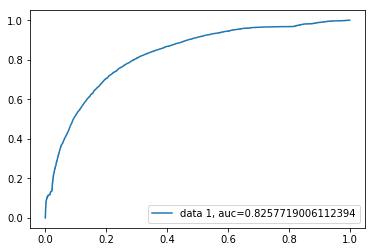

MCC:
0.5058638953814312
Time to run 9.1010000705719

Random Forest 0
 
Confusion Matrix: [[8859 1931]
 [2266 5265]]
Accuracy: 0.7709186179793679
Precision: 0.7316564758198999
Recall: 0.6991103439118311


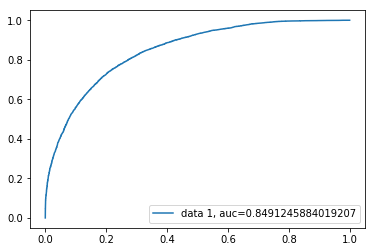

MCC:
0.5240451156618641
Time to run 6.0401999950408936
Logistic Regression 1


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[9594 1229]
 [5745 1753]]
Accuracy: 0.619343922274985
Precision: 0.5878604963112005
Recall: 0.23379567884769273


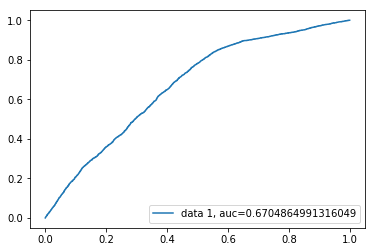

MCC:
0.16015759823432038
Time to run 0.4181997776031494

Decision Tree 1
 
Confusion Matrix: [[8564 2259]
 [2250 5248]]
Accuracy: 0.753888979859178
Precision: 0.6990808578659917
Recall: 0.6999199786609762


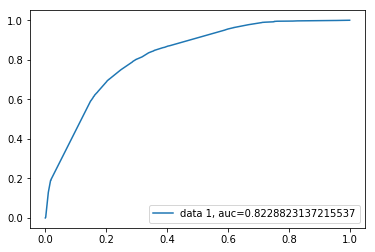

MCC:
0.49110751646900735
Time to run 0.6308000087738037

Boosted Trees 1
 
Confusion Matrix: [[8796 2027]
 [2247 5251]]
Accuracy: 0.7667157906227826
Precision: 0.7214894201703764
Recall: 0.7003200853560949


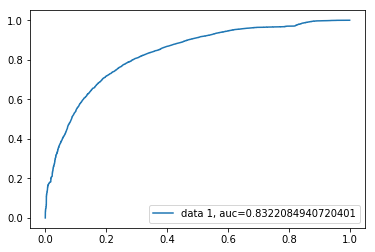

MCC:
0.5155169179930247
Time to run 10.210999965667725

Random Forest 1
 
Confusion Matrix: [[8879 1944]
 [2263 5235]]
Accuracy: 0.7703727962447464
Precision: 0.7292101964061847
Recall: 0.6981861829821285


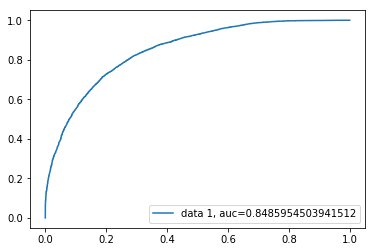

MCC:
0.5223231741919643
Time to run 6.384000062942505
Logistic Regression 2


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[9656 1023]
 [5986 1656]]
Accuracy: 0.6174335462038099
Precision: 0.6181410974244121
Recall: 0.21669719968594608


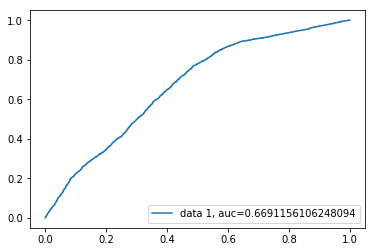

MCC:
0.1687208549261049
Time to run 0.3804001808166504

Decision Tree 2
 
Confusion Matrix: [[8572 2107]
 [2446 5196]]
Accuracy: 0.7514873642268435
Precision: 0.7114884294125702
Recall: 0.6799267207537294


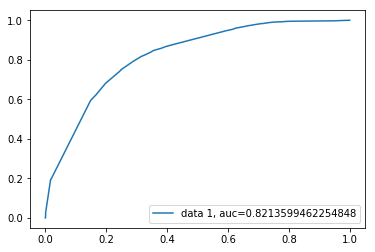

MCC:
0.4860437161044896
Time to run 0.5590000152587891

Boosted Trees 2
 
Confusion Matrix: [[8590 2089]
 [2300 5342]]
Accuracy: 0.7604388406746356
Precision: 0.7188803660341812
Recall: 0.6990316671028527


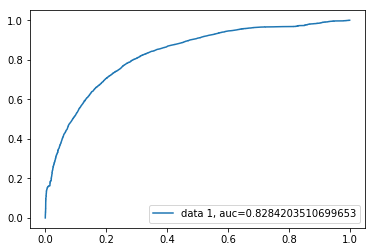

MCC:
0.505541269573008
Time to run 9.691200017929077

Random Forest 2
 
Confusion Matrix: [[8761 1918]
 [2339 5303]]
Accuracy: 0.7676436875716391
Precision: 0.7343858191386234
Recall: 0.6939282910232923


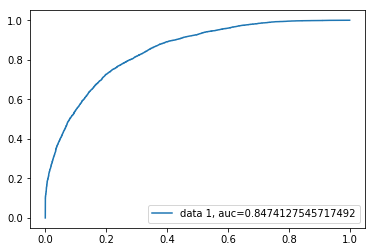

MCC:
0.5189732602298261
Time to run 5.852800130844116
Logistic Regression 3


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[9672 1110]
 [5799 1740]]
Accuracy: 0.6228917635500245
Precision: 0.6105263157894737
Recall: 0.23079984082769597


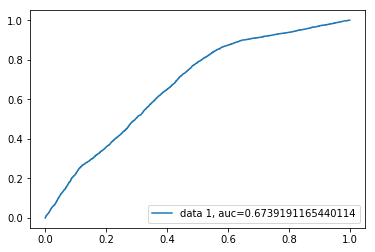

MCC:
0.17359102913065064
Time to run 0.3896000385284424

Decision Tree 3
 
Confusion Matrix: [[8491 2291]
 [2246 5293]]
Accuracy: 0.7523606790022379
Precision: 0.6979166666666666
Recall: 0.7020825043109166


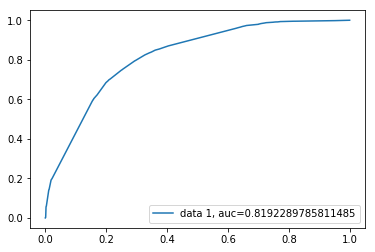

MCC:
0.4891659104060576
Time to run 0.5612001419067383

Boosted Trees 3
 
Confusion Matrix: [[8705 2077]
 [2326 5213]]
Accuracy: 0.7596746902461656
Precision: 0.7150891632373114
Recall: 0.6914710173763099


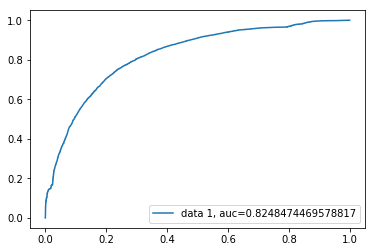

MCC:
0.5015247507289073
Time to run 9.786999940872192

Random Forest 3
 
Confusion Matrix: [[8853 1929]
 [2290 5249]]
Accuracy: 0.7697178101632007
Precision: 0.7312621900250766
Recall: 0.6962461864968829


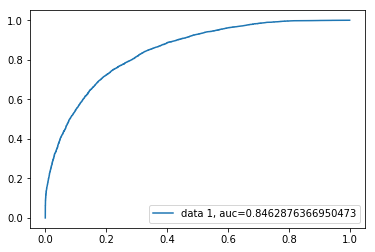

MCC:
0.5215274762585086
Time to run 5.53980016708374
Logistic Regression 4


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[9599 1191]
 [5811 1720]]
Accuracy: 0.6178156214180449
Precision: 0.5908622466506355
Recall: 0.22838932412694196


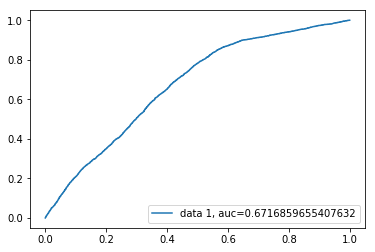

MCC:
0.15882944389557255
Time to run 0.38540005683898926

Decision Tree 4
 
Confusion Matrix: [[8555 2235]
 [2254 5277]]
Accuracy: 0.754980623328421
Precision: 0.7024760383386581
Recall: 0.7007037578010888


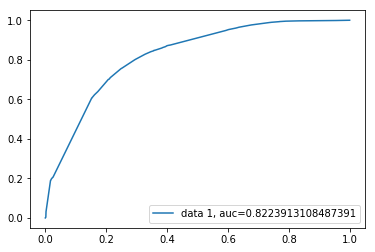

MCC:
0.493756778774491
Time to run 0.6007997989654541

Boosted Trees 4
 
Confusion Matrix: [[8686 2104]
 [2183 5348]]
Accuracy: 0.7660062223677747
Precision: 0.7176596886741814
Recall: 0.7101314566458637


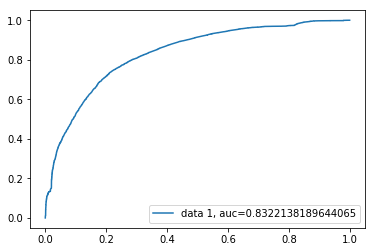

MCC:
0.5159739861722659
Time to run 9.901600122451782

Random Forest 4
 
Confusion Matrix: [[8816 1974]
 [2228 5303]]
Accuracy: 0.7706457071120572
Precision: 0.7287343685584718
Recall: 0.7041561545611472


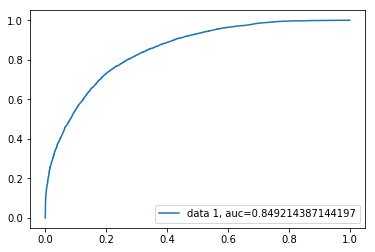

MCC:
0.5240944375706436
Time to run 5.858000040054321
Logistic Regression 5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[9751 1156]
 [5667 1747]]
Accuracy: 0.6275858304677693
Precision: 0.601791250430589
Recall: 0.23563528459670893


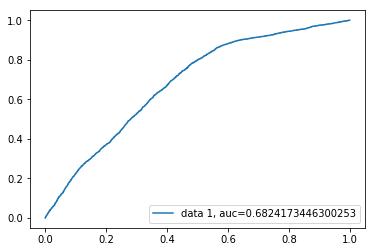

MCC:
0.17426422849804246
Time to run 0.38140010833740234

Decision Tree 5
 
Confusion Matrix: [[8267 2640]
 [1833 5581]]
Accuracy: 0.7558539381038153
Precision: 0.6788711835543121
Recall: 0.7527650391151874


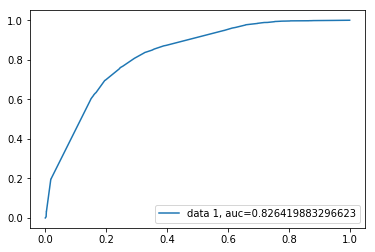

MCC:
0.5040082566757621
Time to run 0.5578000545501709

Boosted Trees 5
 
Confusion Matrix: [[8823 2084]
 [2140 5274]]
Accuracy: 0.76944489929589
Precision: 0.7167708616471867
Recall: 0.7113568923657945


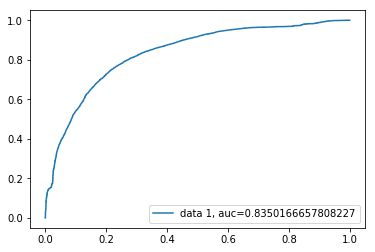

MCC:
0.5209274835497762
Time to run 9.280999898910522

Random Forest 5
 
Confusion Matrix: [[8986 1921]
 [2134 5280]]
Accuracy: 0.7786692866109929
Precision: 0.7332314956256075
Recall: 0.712166172106825


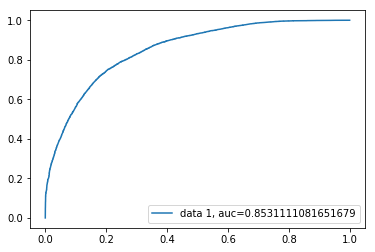

MCC:
0.5386764048109614
Time to run 5.81220006942749
Logistic Regression 6


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[9643 1146]
 [5792 1740]]
Accuracy: 0.6213088805196223
Precision: 0.6029106029106029
Recall: 0.23101433882103026


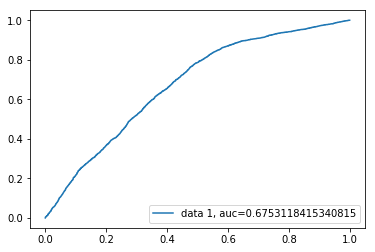

MCC:
0.16855498502943234
Time to run 0.3824000358581543

Decision Tree 6
 
Confusion Matrix: [[8669 2120]
 [2401 5131]]
Accuracy: 0.7532339937776322
Precision: 0.707626534271135
Recall: 0.6812267657992565


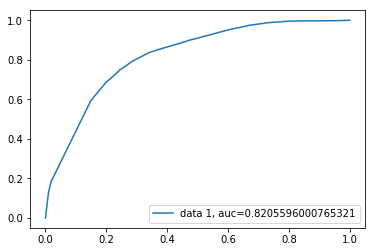

MCC:
0.4877229452924264
Time to run 0.556999921798706

Boosted Trees 6
 
Confusion Matrix: [[8719 2070]
 [2217 5315]]
Accuracy: 0.7660062223677747
Precision: 0.7197020988490183
Recall: 0.7056558682952735


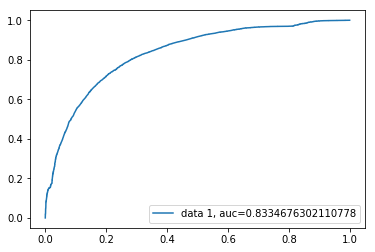

MCC:
0.5153830122966688
Time to run 9.205000162124634

Random Forest 6
 
Confusion Matrix: [[8853 1936]
 [2280 5252]]
Accuracy: 0.7698815566835872
Precision: 0.7306622148024485
Recall: 0.6972915560276155


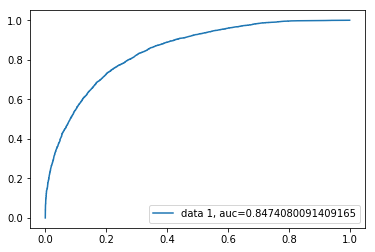

MCC:
0.5218422059074377
Time to run 5.6458001136779785
Logistic Regression 7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[9616 1225]
 [5730 1750]]
Accuracy: 0.6203809835707658
Precision: 0.5882352941176471
Recall: 0.2339572192513369


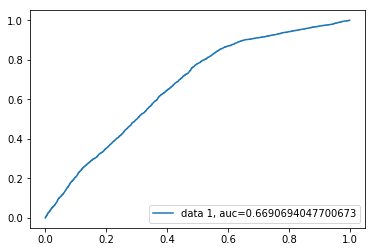

MCC:
0.16120819394941413
Time to run 0.381000280380249

Decision Tree 7
 
Confusion Matrix: [[8644 2197]
 [2327 5153]]
Accuracy: 0.7530702472572458
Precision: 0.7010884353741497
Recall: 0.688903743315508


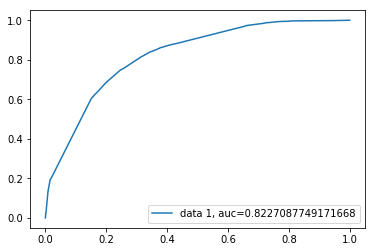

MCC:
0.48761355899670616
Time to run 0.5479998588562012

Boosted Trees 7
 
Confusion Matrix: [[8672 2169]
 [2144 5336]]
Accuracy: 0.7645870858577588
Precision: 0.7109926715522985
Recall: 0.7133689839572193


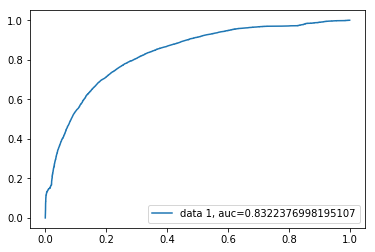

MCC:
0.5130314369902322
Time to run 9.240600109100342

Random Forest 7
 
Confusion Matrix: [[8905 1936]
 [2199 5281]]
Accuracy: 0.7743027127340211
Precision: 0.7317444921712623
Recall: 0.7060160427807487


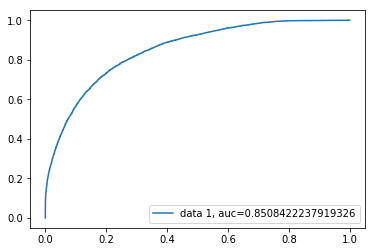

MCC:
0.530561968948639
Time to run 5.583000183105469
Logistic Regression 8


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[9595 1173]
 [5785 1768]]
Accuracy: 0.6202172370503793
Precision: 0.6011560693641619
Recall: 0.23407917383820998


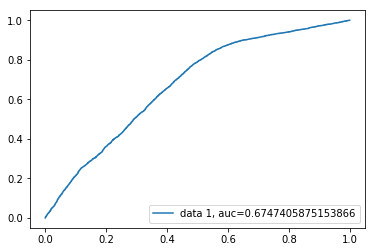

MCC:
0.1678093342996146
Time to run 0.3713998794555664

Decision Tree 8
 
Confusion Matrix: [[8107 2661]
 [1901 5652]]
Accuracy: 0.7509961246656842
Precision: 0.6798989534464093
Recall: 0.7483119290348206


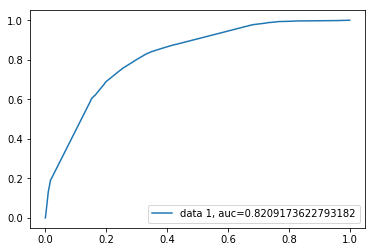

MCC:
0.4955390034394241
Time to run 0.6031999588012695

Boosted Trees 8
 
Confusion Matrix: [[8712 2056]
 [2240 5313]]
Accuracy: 0.7655149828066153
Precision: 0.7209933505224589
Recall: 0.7034291010194624


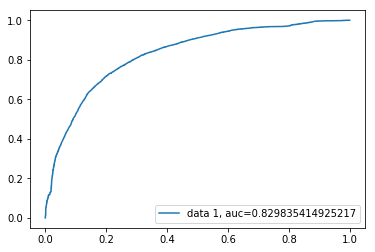

MCC:
0.5144749134384643
Time to run 9.352999925613403

Random Forest 8
 
Confusion Matrix: [[8848 1920]
 [2245 5308]]
Accuracy: 0.7726652475301566
Precision: 0.7343663530713891
Recall: 0.7027671124056666


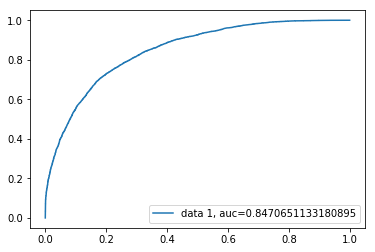

MCC:
0.5282103452797714
Time to run 5.683000087738037
Logistic Regression 9


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 
Confusion Matrix: [[9678 1177]
 [5701 1765]]
Accuracy: 0.6245838109273512
Precision: 0.5999320190346703
Recall: 0.2364050361639432


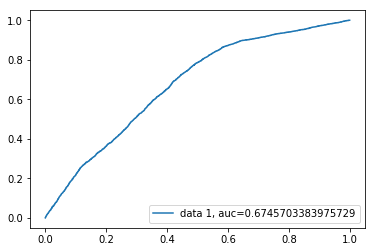

MCC:
0.17127783967870241
Time to run 0.3899998664855957

Decision Tree 9
 
Confusion Matrix: [[8604 2251]
 [2296 5170]]
Accuracy: 0.7518148572676164
Precision: 0.6966716076000539
Recall: 0.6924725421912671


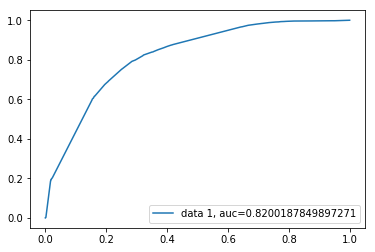

MCC:
0.48556581506759194
Time to run 0.597599983215332

Boosted Trees 9
 
Confusion Matrix: [[8762 2093]
 [2179 5287]]
Accuracy: 0.7668249549697069
Precision: 0.7163956639566396
Recall: 0.7081435842485936


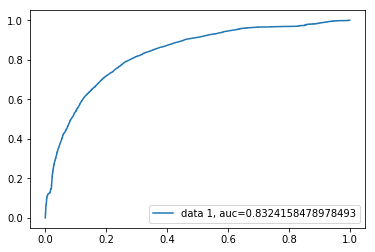

MCC:
0.5162819945735059
Time to run 9.381400108337402

Random Forest 9
 
Confusion Matrix: [[8890 1965]
 [2222 5244]]
Accuracy: 0.7714644397139894
Precision: 0.7274240532667499
Recall: 0.7023841414412001


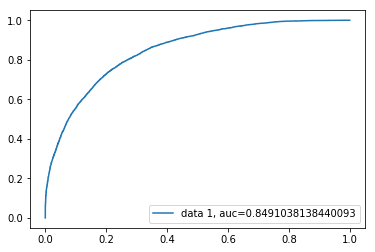

MCC:
0.5244019456613822
Time to run 5.797399997711182
Logistic Regression accuracy: [0.6228371813765624, 0.619343922274985, 0.6174335462038099, 0.6228917635500245, 0.6178156214180449, 0.6275858304677693, 0.6213088805196223, 0.6203809835707658, 0.6202172370503793, 0.6245838109273512] [<matplotlib.lines.Line2D object at 0x000000000CB53EB8>]
Logistic Regression precision: [0.618828932261768, 0.5878604963112005, 0.6181410974244121, 0.6105263157894737, 0.5908622466506355, 0.601791250430589, 0.6029106029106029, 0.5882352941176471, 0.6011560693641619, 0.5999320190346703] [<matplotlib.lines.Line2D object at 0x000000000CB53518>]
Logistic Regression recall: [0.21471252157747975, 0.23379567884769273, 0.21669719968594608, 0.23079984082769597, 0.22838932412694196, 0.23563528459670893, 0.23101433882103026, 0.2339572192513369, 0.23407917383820998, 0.2364050361639432] [<matplotlib.lines.Line2D object at 0x000000000CB537F0>]
Logistic Regression AUROC: [0.6752971252957654, 0.6704864991316049, 0.66911561

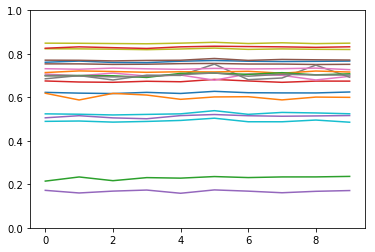

In [49]:
acc_logreg = []
prec_logreg = []
rec_logreg = []
aur_logreg = []
mcc_logreg = []

acc_tree = []
prec_tree = []
rec_tree = []
aur_tree = []
mcc_tree = []

acc_booster = []
prec_booster = []
rec_booster = []
aur_booster = []
mcc_booster = []

acc_forest = []
prec_forest = []
rec_forest = []
aur_forest = []
mcc_forest = []

for i in range (0,10):
    X_train2,X_test2,y_train2,y_test2=train_test_split(Xad4,Yad4,test_size=0.25,random_state=i)
    print('Logistic Regression', i)
    logreg1 = modelrun(model =logreg, xtrain=X_train2, ytrain=y_train2, xtest = X_test2, ytest=y_test2)
    logreg_append(logreg1)
    print('')
    print('Decision Tree', i)
    tree1 = modelrun(model =clf_tree, xtrain=X_train2, ytrain=y_train2, xtest = X_test2, ytest=y_test2)
    tree_append(tree1)
    print('')
    print('Boosted Trees', i)
    boost1 = modelrun(model = booster, xtrain=X_train2, ytrain=y_train2, xtest = X_test2, ytest=y_test2)
    boost_append(boost1)
    print('')
    print('Random Forest', i)
    forest1 = modelrun(model =forest, xtrain=X_train2, ytrain=y_train2, xtest = X_test2, ytest=y_test2)
    forest_append(forest1)
    

print("Logistic Regression accuracy:",acc_logreg, plt.plot(acc_logreg, scaley=False))
print("Logistic Regression precision:",prec_logreg, plt.plot(prec_logreg, scaley=False))
print("Logistic Regression recall:",rec_logreg, plt.plot(rec_logreg, scaley=False))
print("Logistic Regression AUROC:",aur_logreg, plt.plot(aur_logreg, scaley=False))
print("Logistic Regression MCC:",mcc_logreg, plt.plot(mcc_logreg, scaley=False)) 

print("Tree Accuracy:",acc_tree, plt.plot(acc_tree, scaley=False))
print("Tree Precision:",prec_tree, plt.plot(prec_tree, scaley=False))
print("Tree Recall:",rec_tree, plt.plot(rec_tree, scaley=False))
print("Tree AUROC:",aur_tree, plt.plot(aur_tree, scaley=False))
print("Tree MCC:",mcc_tree, plt.plot(mcc_tree, scaley=False))

print("Boosted Tree Accuracy:",acc_booster, plt.plot(acc_booster, scaley=False))
print("Boosted Tree Precision:",prec_booster, plt.plot(prec_booster, scaley=False))
print("Boosted Tree Recall:",rec_booster, plt.plot(rec_booster, scaley=False))
print("Boosted Tree AUROC:",aur_booster, plt.plot(aur_booster, scaley=False))
print("Boosted Tree MCC:",mcc_booster, plt.plot(mcc_booster, scaley=False))

print("Forest Accuracy:",acc_forest, plt.plot(acc_forest, scaley=False))
print("Forect Precision:",prec_forest, plt.plot(prec_forest, scaley=False))
print("Forest Recall:",rec_forest, plt.plot(rec_forest, scaley=False))
print("Forest AUROC:",aur_forest, plt.plot(aur_forest, scaley=False))
print("Forest MCC:",mcc_forest, plt.plot(mcc_forest, scaley=False)) 

In [ ]:
## Now conduct statistical comparison tests to determine if the models perform
#differntly from each other
#Start with logistic regression


#lr_acc_orig = acc_logreg.copy()
#lr_prec_orig = prec_logreg.copy()
#lr_rec_orig = rec_logreg.copy()
#lr_auroc_orig = aur_logreg.copy()
#lr_mcc_orig = mcc_logreg.copy()

#tree_acc_orig = acc_tree.copy()
#tree_prec_orig = prec_tree.copy()
#tree_rec_orig = rec_tree.copy()
#tree_auroc_orig = aur_tree.copy()
#tree_mcc_orig = mcc_tree.copy()

#boost_acc_orig = acc_booster.copy()
#boost_prec_orig = prec_booster.copy()
#boost_rec_orig = rec_booster.copy()
#boost_auroc_orig = aur_booster.copy()
#pboost_mcc_orig = mcc_booster.copy()

#forest_acc_orig = acc_forest.copy()
#forest_prec_orig = prec_forest.copy()
#forest_rec_orig = rec_forest.copy()
#forest_auroc_orig = aur_forest.copy()
#forest_mcc_orig = mcc_forest.copy()

(array([3., 0., 1., 2., 1., 0., 0., 0., 1., 2.]),
 array([0.72697997, 0.72760221, 0.72822444, 0.72884668, 0.72946892,
        0.73009115, 0.73071339, 0.73133563, 0.73195786, 0.7325801 ,
        0.73320234]),
 <a list of 10 Patch objects>)

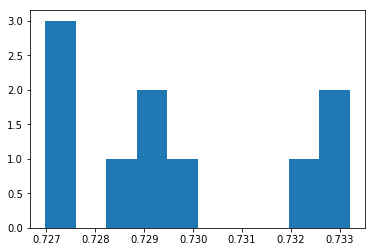

In [31]:
plt.hist(lr_acc_orig)
#distributions are non-normal so should use a non-parametric test

In [72]:
def wilcox(d1, d2):
    stat, p = wilcoxon(d1, d2)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    alpha = 0.05
    if p > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')
    print(statistics.mean(d1), statistics.mean(d2))

In [73]:
wilcox(lr_acc_orig, tree_acc_orig)

Statistics=0.000, p=0.005
Different distribution (reject H0)
0.7295999126685224 0.7095355057038372


In [74]:
wilcox(lr_acc_orig, boost_acc_orig)

Statistics=1.000, p=0.011
Different distribution (reject H0)
0.7295999126685224 0.7276458708585776


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


In [75]:
wilcox(lr_acc_orig, forest_acc_orig)

Statistics=23.000, p=0.646
Same distribution (fail to reject H0)
0.7295999126685224 0.7299601550133726


In [76]:
wilcox(tree_acc_orig, boost_acc_orig)

Statistics=0.000, p=0.005
Different distribution (reject H0)
0.7095355057038372 0.7276458708585776


In [77]:
wilcox(tree_acc_orig, forest_acc_orig)

Statistics=0.000, p=0.005
Different distribution (reject H0)
0.7095355057038372 0.7299601550133726


In [78]:
wilcox(boost_acc_orig, forest_acc_orig)

Statistics=0.000, p=0.005
Different distribution (reject H0)
0.7276458708585776 0.7299601550133726


In [94]:
#All models behave differently with the exception of logistic regression and
#random forest - for these models, check the other metric
print("Precision")
wilcox(lr_prec_orig, forest_prec_orig)
print("Recall")
wilcox(lr_rec_orig, forest_rec_orig)
print("AUROC")
wilcox(lr_auroc_orig, forest_auroc_orig)
print("MCC")
wilcox(lr_mcc_orig, forest_mcc_orig)
##Models perform differently in terms of precision, recall, and AUROC

Precision
Statistics=6.000, p=0.028
Different distribution (reject H0)
0.6818346305600662 0.6854270570752844
Recall
Statistics=0.000, p=0.005
Different distribution (reject H0)
0.6395464886197733 0.6322555878825973
AUROC
Statistics=2.000, p=0.009
Different distribution (reject H0)
0.7999143454912683 0.8016859867145584
MCC
Statistics=26.000, p=0.878
Same distribution (fail to reject H0)
0.43654970596571624 0.436374922838253


In [85]:
##Compare original models with models including social variables
#Accuracy
print("LR")
wilcox(lr_acc_orig, lr_accuracy_social)

print("Tree")
wilcox(tree_acc_orig, tree_accuracy_social)

print("Boosted Trees")
wilcox(boost_acc_orig, boost_acc_social)

print("Random Forest")
wilcox(forest_acc_orig, forest_acc_social)

LR
Statistics=0.000, p=0.005
Different distribution (reject H0)
0.7295999126685224 0.6363408110910976
Tree
Statistics=0.000, p=0.005
Different distribution (reject H0)
0.7095355057038372 0.754931499372305
Boosted Trees
Statistics=0.000, p=0.005
Different distribution (reject H0)
0.7276458708585776 0.7652202390699198
Random Forest
Statistics=0.000, p=0.005
Different distribution (reject H0)
0.7299601550133726 0.7754543965940723


In [86]:
##Compare original models with models including social variables
#Precision
print("LR")
wilcox(lr_prec_orig, lr_prec_social)

print("Tree")
wilcox(tree_prec_orig, tree_prec_social)

print("Boosted Trees")
wilcox(boost_prec_orig, boost_prec_social)

print("Random Forest")
wilcox(forest_prec_orig, forest_prec_social)

LR
Statistics=0.000, p=0.005
Different distribution (reject H0)
0.6818346305600662 0.6075348041869778
Tree
Statistics=0.000, p=0.005
Different distribution (reject H0)
0.6519967611638688 0.7039488077448439
Boosted Trees
Statistics=0.000, p=0.005
Different distribution (reject H0)
0.6763571405814429 0.7206932625013456
Random Forest
Statistics=0.000, p=0.005
Different distribution (reject H0)
0.6854270570752844 0.7349760569502334


In [88]:
##Compare original models with models including social variables
#Recall
print("LR")
wilcox(lr_rec_orig, lr_rec_social)

print("Tree")
wilcox(tree_rec_orig, tree_rec_social)

print("Boosted Trees")
wilcox(boost_rec_orig, boost_rec_social)

print("Random Forest")
wilcox(forest_rec_orig, forest_rec_social)

LR
Statistics=0.000, p=0.005
Different distribution (reject H0)
0.6395464886197733 0.32197333698067415
Tree
Statistics=0.000, p=0.005
Different distribution (reject H0)
0.6269056923775581 0.6957159626792104
Boosted Trees
Statistics=0.000, p=0.005
Different distribution (reject H0)
0.6450359607948899 0.6987579720814664
Random Forest
Statistics=0.000, p=0.005
Different distribution (reject H0)
0.6322555878825973 0.7082258285904443


In [90]:
##Compare original models with models including social variables
#AUROC
print("LR")
wilcox(lr_auroc_orig, lr_auroc_social)

print("Tree")
wilcox(tree_auroc_orig, tree_auroc_social)

print("Boosted Trees")
wilcox(boost_auroc_orig, boost_auroc_social)

print("Random Forest")
wilcox(forest_auroc_orig, forest_auroc_social)

LR
Statistics=0.000, p=0.005
Different distribution (reject H0)
0.7999143454912683 0.6947190850524504
Tree
Statistics=0.000, p=0.005
Different distribution (reject H0)
0.7705751671864621 0.8222277696828331
Boosted Trees
Statistics=0.000, p=0.005
Different distribution (reject H0)
0.7961283087578234 0.8270475137453945
Random Forest
Statistics=0.000, p=0.005
Different distribution (reject H0)
0.8016859867145584 0.8524365822159048


In [93]:
##Compare original models with models including social variables
#MCC
print("LR")
wilcox(lr_mcc_orig, lr_mcc_social)

print("Tree")
wilcox(tree_mcc_orig, tree_mcc_social)

print("Boosted Trees")
wilcox(pboost_mcc_orig, pboost_mcc_social)

print("Random Forest")
wilcox(forest_mcc_orig, forest_mcc_social)

LR
Statistics=0.000, p=0.005
Different distribution (reject H0)
0.43654970596571624 0.21124586665537332
Tree
Statistics=0.000, p=0.005
Different distribution (reject H0)
0.396518222970807 0.49290718361109664
Boosted Trees
Statistics=0.000, p=0.005
Different distribution (reject H0)
0.43358545923736347 0.5128057994077985
Random Forest
Statistics=0.000, p=0.005
Different distribution (reject H0)
0.436374922838253 0.5336851434893581


In [95]:
##Compare models with VALUE and visitbyday individually
#Accuracy
print("LR")
wilcox(lr_acc_orig, lr_accuracy_vbd)

print("Tree")
wilcox(tree_acc_orig, tree_accuracy_vbd)

print("Boosted Trees")
wilcox(boost_acc_orig, boost_acc_vbd)

print("Random Forest")
wilcox(forest_acc_orig, forest_acc_vbd)

LR
Statistics=0.000, p=0.005
Different distribution (reject H0)
0.7295999126685224 0.6224387315102887
Tree
Statistics=0.000, p=0.005
Different distribution (reject H0)
0.7095355057038372 0.7545930898968397
Boosted Trees
Statistics=0.000, p=0.005
Different distribution (reject H0)
0.7276458708585776 0.7642159270782163
Random Forest
Statistics=0.000, p=0.005
Different distribution (reject H0)
0.7299601550133726 0.7732765678729328


In [101]:
##Compare models with VALUE and visitbyday individually
#Accuracy
print("LR")
wilcox(lr_accuracy_social, lr_accuracy_vbd)

print("Tree")
wilcox(tree_accuracy_social, tree_accuracy_vbd)

print("Boosted Trees")
wilcox(boost_acc_social, boost_acc_vbd)

print("Random Forest")
wilcox(forest_acc_social, forest_acc_vbd)

LR
Statistics=0.000, p=0.005
Different distribution (reject H0)
0.6363408110910976 0.6224387315102887
Tree
Statistics=17.000, p=0.284
Same distribution (fail to reject H0)
0.754931499372305 0.7545930898968397
Boosted Trees
Statistics=15.000, p=0.203
Same distribution (fail to reject H0)
0.7652202390699198 0.7642159270782163
Random Forest
Statistics=1.000, p=0.007
Different distribution (reject H0)
0.7754543965940723 0.7732765678729328


In [106]:
##Compare models with VALUE and visitbyday individually
#Accuracy
print("LR")
wilcox(lr_accuracy_social, acc_logreg)

print("Tree")
wilcox(tree_accuracy_social, acc_tree)

print("Boosted Trees")
wilcox(boost_acc_social, acc_booster)

print("Random Forest")
wilcox(forest_acc_social, acc_forest)


LR
Statistics=0.000, p=0.005
Different distribution (reject H0)
0.6363408110910976 0.6214398777359315
Tree
Statistics=1.000, p=0.007
Different distribution (reject H0)
0.754931499372305 0.7531575787347853
Boosted Trees
Statistics=15.000, p=0.374
Same distribution (fail to reject H0)
0.7652202390699198 0.7646635009006059
Random Forest
Statistics=0.000, p=0.005
Different distribution (reject H0)
0.7754543965940723 0.7716281862343759


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


In [ ]:
#Fairly simlar across all models, with some slight superior performance with
#both variables
#Next steps could be to test the rest of the measures and choose one of the variables